---
title: "Youtube API Scraping of Spiritual Channels"
description: "Finding what Makes Spiritual Channels A Hit"
format:
    html:
        code-fold: true
render-on-save: true
jupyter: python3
output:
  quarto::html_document:
    self_contained: false
    keep_md: false

categories:
    - Web Scraping 
    - Data Analysis

image: ./images/Yt_Scraping.png
---

# Exploratory Data Anlysis Using Youtube Data Videos from Most Popular Indian Spirituality Channels

## 1. Aims, Objectives, Steps & Background

### 1.1 Introduction

With millions of users and billions of views, YouTube has become a major platform for spirituality content creators to share their knowledge and insights with a global audience. However, understanding what makes a video successful on YouTube can be a challenge, as the platform's algorithm is complex and constantly evolving. Aspiring spirituality content creators can benefit from analyzing successful channels in their niche and identifying trends in their topics and presentation styles. In this project, we will explore the statistics 
of 9 popular spirituality channels on YouTube to gain insights on their audience, content, and engagement metrics.

### 1.2 Aims and Objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?

- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
- Which questions are being asked in the comment sections in the videos

### 1.3 Steps of the project

- Obtain video meta data via the API app, from top 10 youtube niche channels.
- Preprocess data and engineer aditional features for analysis
- Exploratory data analysis
- Conclusions

### 1.4 Dataset

- Created my own dataset usign the Google API version 3.0
- The channels are included as per my liking and self-thoughts about spirituality. 
- Also I have chosen channels based on their subscriber counts.

## Library Imports

In [158]:
import pandas as pd
import os
import time
import numpy as np
from dateutil import parser
import isodate
import datetime

# Data visualization libraries
import matplotlib
#matplotlib.use('TkAgg') #default backend 'module://matplotlib_inline.backend_inline'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import seaborn as sns
sns.set(style = 'darkgrid', color_codes=True)
sns.set(rc={'figure.figsize':(10,8),'figure.dpi':150}) #fig = plt.figure(dpi=200,figsize = (16,20)) similar
#matplotlib.use("TkAgg")
%matplotlib inline
# #plt.rcParams['font.family'] = 'Lohit-Devanagari'
# #plt.rcParams["font.path"] = "/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"
# english_font = fm.FontProperties(family = 'Arial', size = 14)
# #mangal_font = fm.FontProperties(fname = "~/downloads/fonts/mangal.ttf",size = 14)
# #%matplotlib inline

#NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
# To install wordcloud use: python -m pip install -e git+https://github.com/amueller/word_cloud#egg=wordcloud
# Google API
from googleapiclient.discovery import build

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuvi_dh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yuvi_dh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Creation with Youtube API

- Created a project on Google Developer Console
- Requested an Authorization Credential API Key
- Enabled Youtube API for the project work to send API requests to Youtube API services. 
- Got the channel ID's from my favorite channels which I would like to get stats on.
- Finally created the functions for getting the channel stats.

In [159]:
api_key_1 = os.environ.get('yt_1')
#api_key_2 = os.environ.get('yt_2')
#api_key_3 = os.environ.get('yt_3')
#api_key = api_key_1
#print(api_key)

In [160]:
import os
api_key_1 = os.environ.get('yt_1')
api_key_2 = os.environ.get('yt_2')
api_key_3 = os.environ.get('yt_3')
api_key = api_key_1
#print(api_key)

# channel_ids = ['UCCy2rLnGdwoJcSAtixNdsPQ', # The Sanskrit Channel
#               'UCzszIh4jH06kYp7k_DxhH5A',  # Chinmaya Channel
#               'UCtDAJiFT4sy42oNPA8zo0sw',  # Star Bharat
#               'UCdsQsaeI8pQZtgrMmbjGUug',  # Swaminarayan Aksharpith
#               'UCqFg6QnwgtVHo1iFgpxrx-A',  # Mayapur TV
#               'UCutvkeF3tVgItCX31QhJ2Dw',  # Nova Spiritual India
#               'UCypj9Vvizo4cCERfDFIG3zw',  # Shemaroo Bhakti Darshan
#               'UCxoQaZS8YdKkyfBwGZay-Xg',  # Hyper Quest
#               'UC8HRYUBXTHv4mJ67Y5FitSg']  # Rajshri Soul
channel_ids = [
    "UCgeicB5AuF3MyyUto0-M5Lw",  # Actualized.org
    "UCOnnmKlDZltHAqJLz-XIpGA",  # Universe Inside You
    "UC48MclMZIY_EaOQwatzCpvw",  # Aaron Doughty
    "UCg3F5jxUrSvJQICen48cX4w",  # Mindvalley
    "UCEcMWs6GudljuLw0-Umf97A",  # Spirit Science
    "UCFVqzO9_qHVckKqNC95o9tw",  # Gaia    
    "UC7IcJI8PUf5Z3zKxnZvTBog",  # The School of Life
    "UCz22l7kbce-uFJAoaZqxD1A",  # Gaur Gopal Das
    "UCFJZQtrh5Ksncayy2FaoNbQ",  # Vishuddha Das
    "UCkJEpR7JmS36tajD34Gp4VA",  # Psych2Go
]
youtube = build('youtube', 'v3',developerKey=api_key)

### Functions

In [161]:
def get_channel_stats(channel_ids,yt=youtube):
    '''
    Get Channel statistics: title subscriber count, view count, video count, upload playlist
    
    Params:
    youtube: the build object from googleapiclient.discovery
    channel_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list
    
    '''
    all_data = []
    request = youtube.channels().list(
        part = 'snippet,contentDetails,statistics,brandingSettings',
        id=','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    #countryName = response['items'][i]['snippet']["country"],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'],
                   publishedAt = isodate.parse_datetime(response['items'][i]['snippet']['publishedAt']))
                    
        all_data.append(data)
    return pd.DataFrame(all_data)

In [162]:
def get_video_ids(playlist_id, max_results=1500,yt = youtube):
    """
    Get list of video IDs of all videos in the given playlist, up to a maximum of 1500 videos
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    max_results: maximum number of videos to retrieve (default: 1500)
    
    Returns:
    List of video IDs of all videos in the playlist, up to the maximum number of videos specified
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = min(max_results, 50))
    response = request.execute()
    
    video_ids = []
    num_videos = 0
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        num_videos += 1
        if num_videos >= max_results:
            break
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages and num_videos < max_results:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = min(max_results - num_videos, 50),
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                num_videos += 1
                if num_videos >= max_results:
                    break
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [163]:
def get_video_details(video_ids,yt = youtube):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [164]:
def get_comments_in_videos(video_ids, yt = youtube):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

### Get Channel statistics

Using the get_channel_stats function defined below, now we are going to obtain the channel statistics for the above channels in scope

In [165]:
channel_data = get_channel_stats(channel_ids)
channel_data.to_csv("./files/spiritual_channel_data_original.csv")

In [166]:
#channel_data

In [167]:
# Creation of copy so that I save a dummy df and also a csv, to not keep reusing youtube credits i.e. 10k per day.
l_channel_data = pd.read_csv("./files/spiritual_channel_data_original.csv",index_col=0)
l_channel_data

channelName  subscribers       views  totalVideos  \
0        Aaron Doughty      1450000   141121587         1793   
1   The School of Life      8380000   820210489          902   
2             Psych2Go     10800000  1477376571         2380   
3                 Gaia      1520000   127649328          645   
4  Universe Inside You      1790000   118060252          126   
5          Mindvalley       2260000   468381830         1662   
6       Gaur Gopal Das      4860000   288878180          356   
7        Vishuddha Das       596000    40838427          381   
8       Actualized.org      1100000   107549192          528   
9       Spirit Science      1300000    79311991          306   

                 playlistId                publishedAt  
0  UU48MclMZIY_EaOQwatzCpvw  2014-07-10 04:24:58+00:00  
1  UU7IcJI8PUf5Z3zKxnZvTBog  2010-05-18 16:46:57+00:00  
2  UUkJEpR7JmS36tajD34Gp4VA  2014-10-05 06:27:31+00:00  
3  UUFVqzO9_qHVckKqNC95o9tw  2008-08-06 15:26:41+00:00  
4  UUOnnmKlDZltHAqJLz-XIpGA  2017-03-30 10:55:39+00:00  
5  UUg3F5jxUrSvJQICen48cX4w  2014-04-23 08:21:13+00:00  
6  UUz22l7kbce-uFJAoaZqxD1A  2016-04-12 18:16:24+00:00  
7  UUFJZQtrh5Ksncayy2FaoNbQ  2014-09-24 14:04:59+00:00  
8  UUgeicB5AuF3MyyUto0-M5Lw  2012-01-23 20:08:34+00:00  
9  UUEcMWs6GudljuLw0-Umf97A  2011-12-29 05:49:29+00:00

In [168]:
# Copy used for further manipulation and original of l_channel_data can be used to load this chdd any time.
chdd = l_channel_data.copy()
chdd

channelName  subscribers       views  totalVideos  \
0        Aaron Doughty      1450000   141121587         1793   
1   The School of Life      8380000   820210489          902   
2             Psych2Go     10800000  1477376571         2380   
3                 Gaia      1520000   127649328          645   
4  Universe Inside You      1790000   118060252          126   
5          Mindvalley       2260000   468381830         1662   
6       Gaur Gopal Das      4860000   288878180          356   
7        Vishuddha Das       596000    40838427          381   
8       Actualized.org      1100000   107549192          528   
9       Spirit Science      1300000    79311991          306   

                 playlistId                publishedAt  
0  UU48MclMZIY_EaOQwatzCpvw  2014-07-10 04:24:58+00:00  
1  UU7IcJI8PUf5Z3zKxnZvTBog  2010-05-18 16:46:57+00:00  
2  UUkJEpR7JmS36tajD34Gp4VA  2014-10-05 06:27:31+00:00  
3  UUFVqzO9_qHVckKqNC95o9tw  2008-08-06 15:26:41+00:00  
4  UUOnnmKlDZltHAqJLz-XIpGA  2017-03-30 10:55:39+00:00  
5  UUg3F5jxUrSvJQICen48cX4w  2014-04-23 08:21:13+00:00  
6  UUz22l7kbce-uFJAoaZqxD1A  2016-04-12 18:16:24+00:00  
7  UUFJZQtrh5Ksncayy2FaoNbQ  2014-09-24 14:04:59+00:00  
8  UUgeicB5AuF3MyyUto0-M5Lw  2012-01-23 20:08:34+00:00  
9  UUEcMWs6GudljuLw0-Umf97A  2011-12-29 05:49:29+00:00

In [169]:
# Setting Numeric n Categorical columns
numeric_cols = ['subscribers','views','totalVideos']
chdd[numeric_cols] = chdd[numeric_cols].apply(pd.to_numeric,errors = 'coerce')

# Convert publishedAt column to datetime
chdd['publishedAt'] =(pd.to_datetime(chdd['publishedAt']))

# Extract year, month, and time into separate columns
chdd['publishingYear'] = chdd['publishedAt'].dt.year
chdd['publishingMonth'] = chdd['publishedAt'].dt.month
chdd['publishingTime'] = chdd['publishedAt'].dt.time

# Get month name
chdd['publishingMonthName'] = chdd['publishedAt'].dt.strftime("%B")

# Dropping the published At column
chdd.drop(['publishedAt'],axis = 1, inplace = True)

In [170]:
# chdd['channelName'] = chdd['channelName'].replace('STAR भारत','Star Bharat')
# chdd 
# Was for other spiritual channels, but isn't necessary now.

In [171]:
chdd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   channelName          10 non-null     object
 1   subscribers          10 non-null     int64 
 2   views                10 non-null     int64 
 3   totalVideos          10 non-null     int64 
 4   playlistId           10 non-null     object
 5   publishingYear       10 non-null     int64 
 6   publishingMonth      10 non-null     int64 
 7   publishingTime       10 non-null     object
 8   publishingMonthName  10 non-null     object
dtypes: int64(5), object(4)
memory usage: 800.0+ bytes


### Popularity Measure via Number of Subscribers Per Channel

In [172]:
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

In [173]:
#matplotlib.use??
#sns.barplot??

In [177]:
# Fixing colors for each channel
#palette = sns.color_palette('pastel6', n_colors=10)
colors = plt.cm.tab10.colors[:10]
#colors = sns.color_palette('Set1', 10)
channel_colors = {}
chdd.sort_values('subscribers',ascending=False,inplace=True)
for i, channel in enumerate(chdd['channelName']):
    channel_colors[channel] = colors[i]

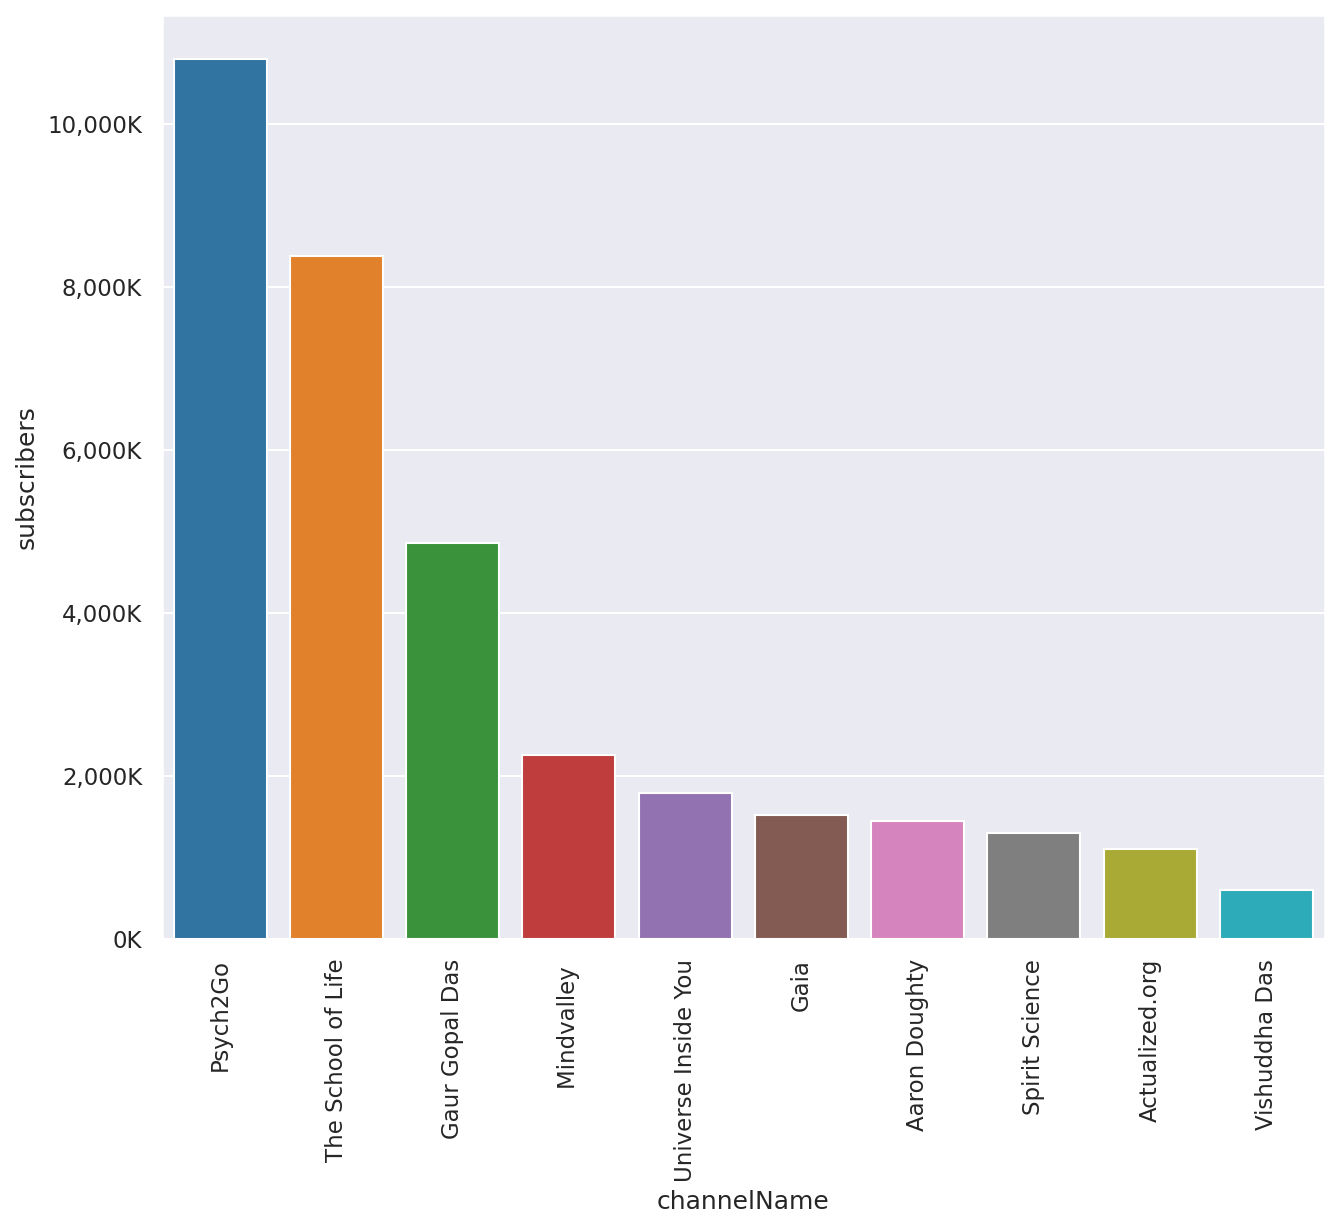

In [178]:
ax = sns.barplot(x='channelName', y='subscribers', data=chdd.sort_values('subscribers', ascending=False), palette=channel_colors)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Popularity measure via Number of Views Per Channel

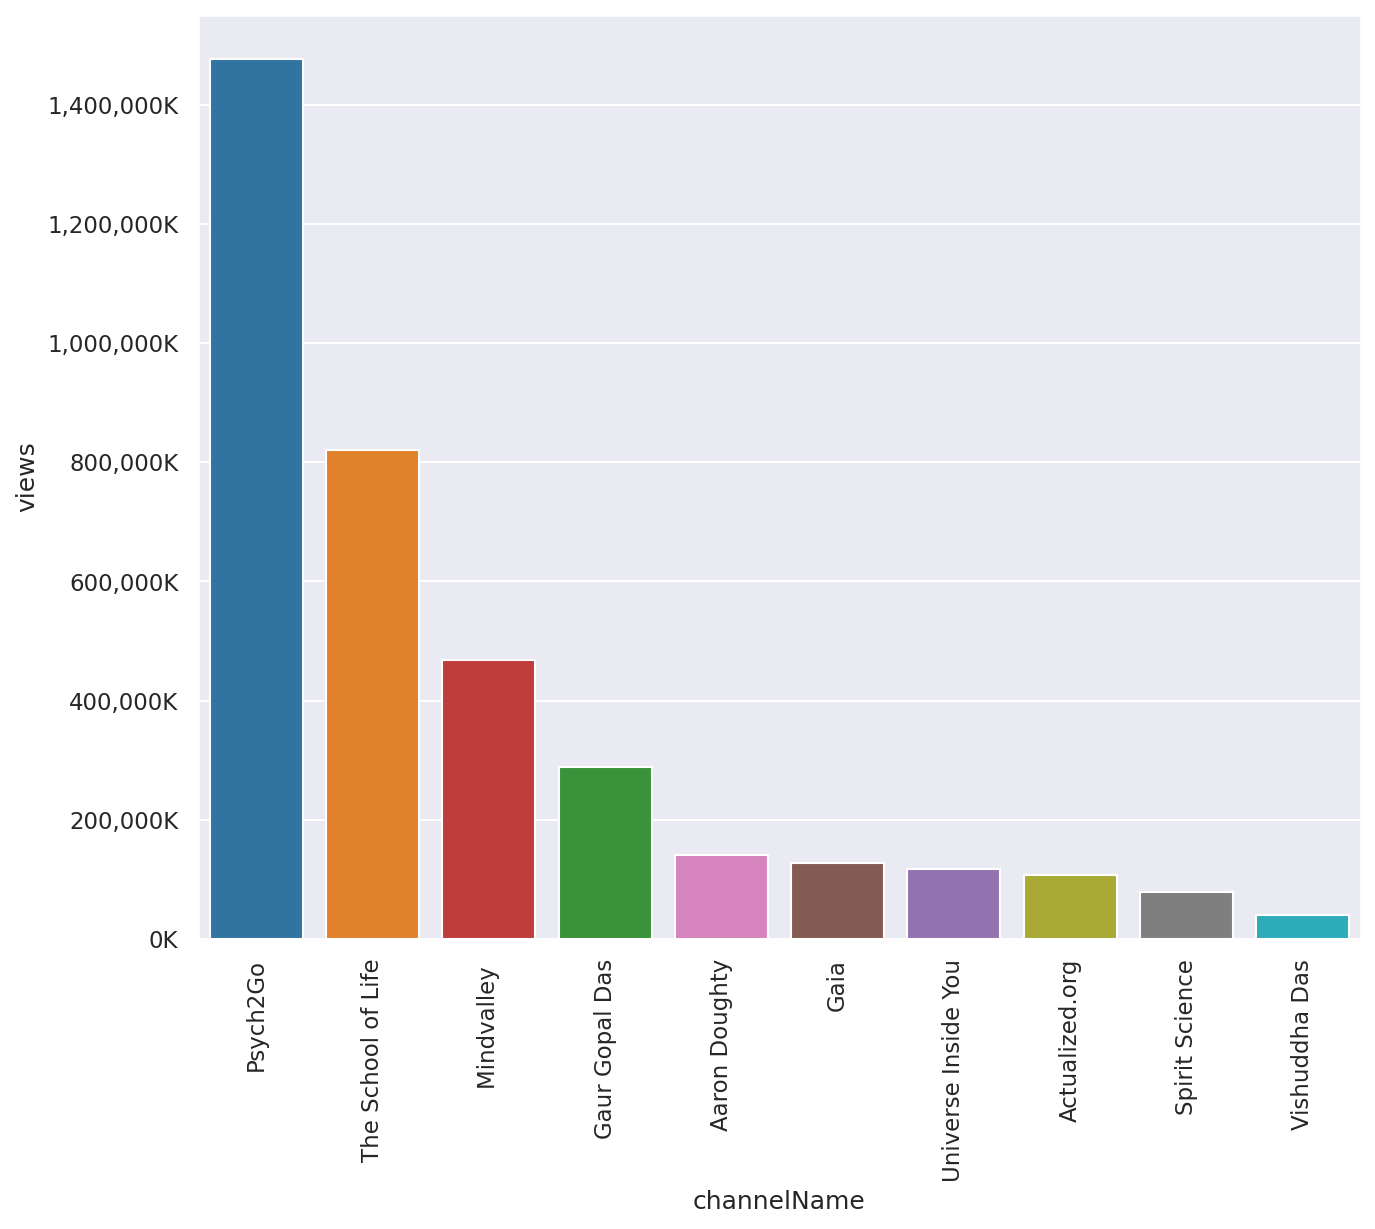

In [179]:
# matplotlib.use('module://matplotlib_inline.backend_inline')
#%matplotlib inline
ax = sns.barplot(x='channelName', y='views', data=chdd.sort_values('views', ascending=False),palette=channel_colors)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

#### Observation from above plots:
- Interestingly, some channels have more subscribers but less views and vice versa. For example, GGD channel has significantly more subscribers than Mind Valley channel, but less views in total.
- Psych2Go and The School of Life hold onto their ranks in both views and subscriber count

### Get video statistics for all the channels

In the next step, we will obtain the video statistics for all the channels. In total, we obtained 8700 videos as seen in below.

In [180]:
# # Create a dataframe with video statistics and comments from all channels
# video_df = pd.DataFrame()
# comments_df = pd.DataFrame()

# for c in channel_data['channelName'].unique():
#     print("Getting video information from channel: " + c)
#     playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
#     video_ids = get_video_ids(playlist_id,max_results=2000,yt = youtube)
    
#     # get video data
#     video_data = get_video_details(video_ids,yt = youtube)
#     # get comment data
#     comments_data = get_comments_in_videos(video_ids,yt = youtube)

#     # append video data together and comment data toghether
#     video_df = video_df.append(video_data, ignore_index=True)
#     comments_df = comments_df.append(comments_data, ignore_index=True)

In [181]:
# video_df.to_csv("./files/spirituality_video_df_original.csv")
# comments_df.to_csv("./files/spirituality_comments_df_original.csv")

In [182]:
l_video_df = pd.read_csv("./files/spirituality_video_df_original.csv",index_col=0)
l_comments_df = pd.read_csv("./files/spirituality_comments_df_original.csv",index_col=0)

In [183]:
viddf = l_video_df.copy()
comdf = l_comments_df.copy()

In [184]:
# Create publish day (in the week) column
viddf['publishedAt'] =  viddf['publishedAt'].apply(lambda x: parser.parse(x)) 
viddf['pushblishDayName'] = viddf['publishedAt'].apply(lambda x: x.strftime("%A"))

# Convert publishedAt column to datetime
viddf['publishedAt'] =(pd.to_datetime(viddf['publishedAt']))


# Extract year, month, and time into separate columns
viddf['publishingYear'] = viddf['publishedAt'].dt.year
viddf['publishingMonth'] = viddf['publishedAt'].dt.month
viddf['publishingTime'] = viddf['publishedAt'].dt.time

# Get month name
viddf['publishingMonthName'] = viddf['publishedAt'].dt.strftime("%B")

# Dropping the published At column
viddf.drop(['publishedAt'],axis = 1, inplace = True)

In [185]:
viddf

video_id    channelTitle  \
0     Q8dOR0bN-Mw            Gaia   
1     Ja1m4mHjZJY            Gaia   
2     qixrU_pwvD0            Gaia   
3     deZsy9GYn8w            Gaia   
4     Kbfpd8zp3mk            Gaia   
...           ...             ...   
8695  ZS3sOfs5jBY  Actualized.org   
8696  mlIYVsuIofs  Actualized.org   
8697  8cbtMhHpLC8  Actualized.org   
8698  C1QYF5WYzCo  Actualized.org   
8699  _874QVgwvEk  Actualized.org   

                                                  title  \
0         Man Able to Project Thoughts Through Crystals   
1     FULL EPISODE: Channeling - A Bridge to the Beyond   
2     This Man Taught Princess Diana to Express Hers...   
3     Mysterious, Ancient Satellite Is Monitoring Earth   
4     How Shamanic Dancing Leads to Altered States o...   
...                                                 ...   
8695                                        Get Coached   
8696                      Be Different to Be Successful   
8697                            Why Life Coaching Works   
8698                          How to Invest In Yourself   
8699                                     Mastery Part 1   

                                            description  \
0     Learn how crystals can hold a powerful place i...   
1     8,000+ Films, Shows & Classes on Gaia. Start Y...   
2     8,000+ Films, Shows & Classes on Gaia. Start Y...   
3     Five of the world’s leading experts unravel my...   
4     8,000+ Films, Shows & Classes on Gaia. Start Y...   
...                                                 ...   
8695  http://www.actualized.org/coaching\n\nResults ...   
8696  How doing things differently in your life is n...   
8697  An explanation of how coaching works and why i...   
8698  How a long-term investment mindset in yourself...   
8699  Test video for self-development blog. This vid...   

                                                   tags  viewCount  likeCount  \
0     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...     7218.0     1309.0   
1     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    18104.0     1394.0   
2     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...     9462.0      640.0   
3     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    73915.0    10072.0   
4     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    14585.0      932.0   
...                                                 ...        ...        ...   
8695         ['life coaching', 'Coaching (Profession)']    10102.0      323.0   
8696                                                NaN    27343.0      929.0   
8697                                                NaN    20081.0      647.0   
8698                                                NaN    61685.0     1805.0   
8699  ['mastery', 'self-help', 'self-development', '...     5496.0      217.0   

      favouriteCount  commentCount  duration definition  caption  \
0                NaN          31.0      PT1M         hd    False   
1                NaN         113.0  PT26M53S         hd    False   
2                NaN          51.0   PT4M47S         hd    False   
3                NaN         338.0      PT1M         hd    False   
4                NaN          54.0   PT3M56S         hd    False   
...              ...           ...       ...        ...      ...   
8695             NaN          31.0  PT16M23S         hd    False   
8696             NaN          41.0   PT26M5S         hd    False   
8697             NaN          42.0     PT21M         hd    False   
8698             NaN         193.0  PT19M13S         hd     True   
8699             NaN          63.0  PT16M12S         hd    False   

     pushblishDayName  publishingYear  publishingMonth publishingTime  \
0            Saturday            2023                4       15:00:28   
1              Friday            2023                3       16:00:07   
2           Wednesday            2023                3       16:00:40   
3             Tuesday            2023                3       15:

Let's take a look at the comment_df as well. We only get 8674 comments in total due to the fact that we limited to 10 first comments on the video to avoid exceeding the Youtube API quota limit.

In [186]:
comdf

video_id                                           comments
0     Q8dOR0bN-Mw  ['Intentionally concentrating the mind setting...
1     Ja1m4mHjZJY  ['8,000+ Films, Shows & Classes on Gaia. Start...
2     qixrU_pwvD0  ['8,000+ Films, Shows & Classes on Gaia. Start...
3     deZsy9GYn8w  ['Watch more of the Awakening Conference with ...
4     Kbfpd8zp3mk  ['8,000+ Films, Shows & Classes on Gaia. Start...
...           ...                                                ...
8669  ZS3sOfs5jBY  ['Thanks', 'A legend is born..', 'Currently go...
8670  mlIYVsuIofs  ['Great video 💫', 'Inspiring', 'Thanks', 'Than...
8671  8cbtMhHpLC8  ['Thanks.', '0:00 a legend was born', 'Magic.'...
8672  C1QYF5WYzCo  ['Thanks', "If you discovered this/him you've ...
8673  _874QVgwvEk  ['Proud of you man. You helped me a lot', 'Who...

[8674 rows x 2 columns]

## Preprocessing & Feature Engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics. Also I removed the favorite count column as it's completely blank, rest other columns having null values weren't modified for simplicity.

### Check for empty values

In [187]:
viddf.isnull().sum(axis = 0)

video_id                  0
channelTitle              0
title                     0
description               3
tags                    554
viewCount                 5
likeCount                 6
favouriteCount         8700
commentCount              8
duration                  0
definition                0
caption                   0
pushblishDayName          0
publishingYear            0
publishingMonth           0
publishingTime            0
publishingMonthName       0
dtype: int64

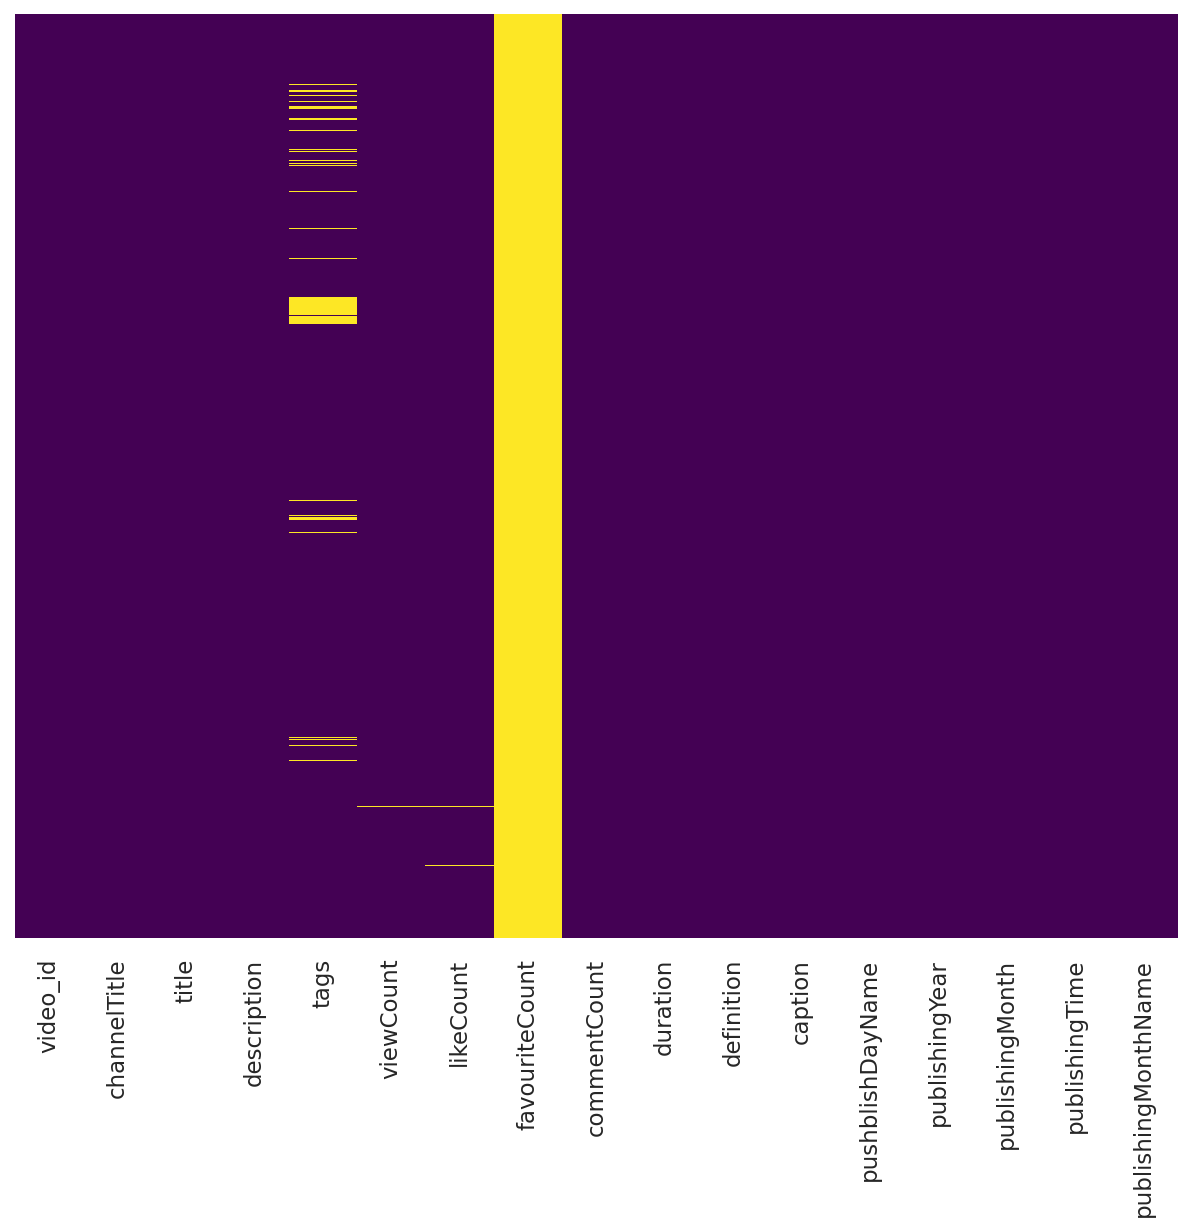

In [188]:
# matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
ax = sns.heatmap(viddf.isnull(),yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

### Formatting Dates

In [189]:
viddf.publishingYear.sort_values().value_counts()
# Videos are from 2011 to 2023
#- During the covid time the channels became more active it seems over all.

2022    1667
2021    1355
2020    1236
2018    1027
2019     950
2017     863
2016     516
2023     392
2015     355
2014     248
2013      45
2012      44
2011       2
Name: publishingYear, dtype: int64

### Correcting Data types


In [190]:
cols = ['viewCount', 'likeCount','commentCount']
viddf[cols] = viddf[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#### Enriching data 

I want to enrich the data for further analyses, for example:
- convert video duration to seconds instead of the current default string format
- calculate number of tags for each video
- calculate comments and likes per 1000 view ratio
- calculate title character length

In [191]:
# convert duration to seconds
viddf['durationSecs'] = viddf['duration'].apply(lambda x: isodate.parse_duration(x))
viddf['durationSecs'] = viddf['durationSecs'].astype('timedelta64[s]')

In [192]:
# Add number of tags
viddf['tagsstr'] = viddf.tags.apply(lambda x: 0 if x is None else str((x))) #tags were not in proper format so converting them to str
viddf['tagsCount'] = viddf.tagsstr.apply(lambda x: 0 if (x == 0 or x =='nan') else len(eval(x)))

In [193]:
# Comments and likes per 1000 view ratio
viddf['likeRatio'] = viddf['likeCount']/ viddf['viewCount'] * 1000
viddf['commentRatio'] = viddf['commentCount']/ viddf['viewCount'] * 1000

In [194]:
# Title character length
viddf['titleLength'] = viddf['title'].apply(lambda x: len(x))

In [195]:
# Dropping the favourite Count as all of it is empty
viddf.drop(['favouriteCount'],axis = 1, inplace=True)

In [196]:
#Observing df before proceeding further
viddf 

video_id    channelTitle  \
0     Q8dOR0bN-Mw            Gaia   
1     Ja1m4mHjZJY            Gaia   
2     qixrU_pwvD0            Gaia   
3     deZsy9GYn8w            Gaia   
4     Kbfpd8zp3mk            Gaia   
...           ...             ...   
8695  ZS3sOfs5jBY  Actualized.org   
8696  mlIYVsuIofs  Actualized.org   
8697  8cbtMhHpLC8  Actualized.org   
8698  C1QYF5WYzCo  Actualized.org   
8699  _874QVgwvEk  Actualized.org   

                                                  title  \
0         Man Able to Project Thoughts Through Crystals   
1     FULL EPISODE: Channeling - A Bridge to the Beyond   
2     This Man Taught Princess Diana to Express Hers...   
3     Mysterious, Ancient Satellite Is Monitoring Earth   
4     How Shamanic Dancing Leads to Altered States o...   
...                                                 ...   
8695                                        Get Coached   
8696                      Be Different to Be Successful   
8697                            Why Life Coaching Works   
8698                          How to Invest In Yourself   
8699                                     Mastery Part 1   

                                            description  \
0     Learn how crystals can hold a powerful place i...   
1     8,000+ Films, Shows & Classes on Gaia. Start Y...   
2     8,000+ Films, Shows & Classes on Gaia. Start Y...   
3     Five of the world’s leading experts unravel my...   
4     8,000+ Films, Shows & Classes on Gaia. Start Y...   
...                                                 ...   
8695  http://www.actualized.org/coaching\n\nResults ...   
8696  How doing things differently in your life is n...   
8697  An explanation of how coaching works and why i...   
8698  How a long-term investment mindset in yourself...   
8699  Test video for self-development blog. This vid...   

                                                   tags  viewCount  likeCount  \
0     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...     7218.0     1309.0   
1     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    18104.0     1394.0   
2     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...     9462.0      640.0   
3     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    73915.0    10072.0   
4     ['gaia', 'yoga on gaia', 'cosmic disclosure', ...    14585.0      932.0   
...                                                 ...        ...        ...   
8695         ['life coaching', 'Coaching (Profession)']    10102.0      323.0   
8696                                                NaN    27343.0      929.0   
8697                                                NaN    20081.0      647.0   
8698                                                NaN    61685.0     1805.0   
8699  ['mastery', 'self-help', 'self-development', '...     5496.0      217.0   

      commentCount  duration definition  ...  publishingYear publishingMonth  \
0             31.0      PT1M         hd  ...            2023               4   
1            113.0  PT26M53S         hd  ...            2023               3   
2             51.0   PT4M47S         hd  ...            2023               3   
3            338.0      PT1M         hd  ...            2023               3   
4             54.0   PT3M56S         hd  ...            2023               3   
...            ...       ...        ...  ...             ...             ...   
8695          31.0  PT16M23S         hd  ...            2013               5   
8696          41.0   PT26M5S         hd  ...            2013               4   
8697          42.0     PT21M         hd  ...            2013               4   
8698         193.0  PT19M13S         hd  ...            2013               4   
8699          63.0  PT16M12S         hd  ...            2012               8   

      publishingTime  publishingMonthName durationSecs  \
0           15:00:28                April         60.0   
1           16:00:07                March       1613.0   
2           16:00:40                Ma

## Exploratory Analysis

### Checking total videos per channel

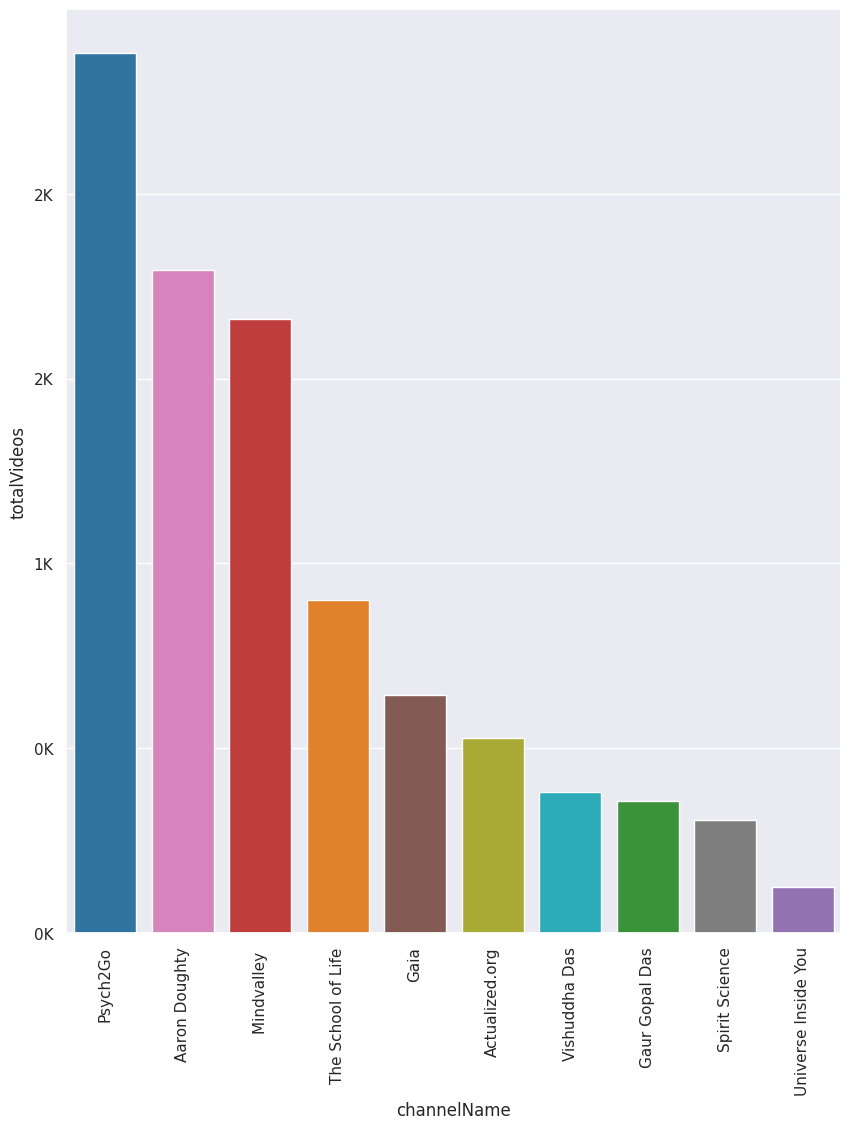

In [197]:
sns.set(rc={'figure.figsize':(10,12),'figure.dpi':100})
ax = sns.barplot(x='channelName', y='totalVideos', data=chdd.sort_values('totalVideos', ascending=False),palette=channel_colors)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Checking number of videos per channel per year

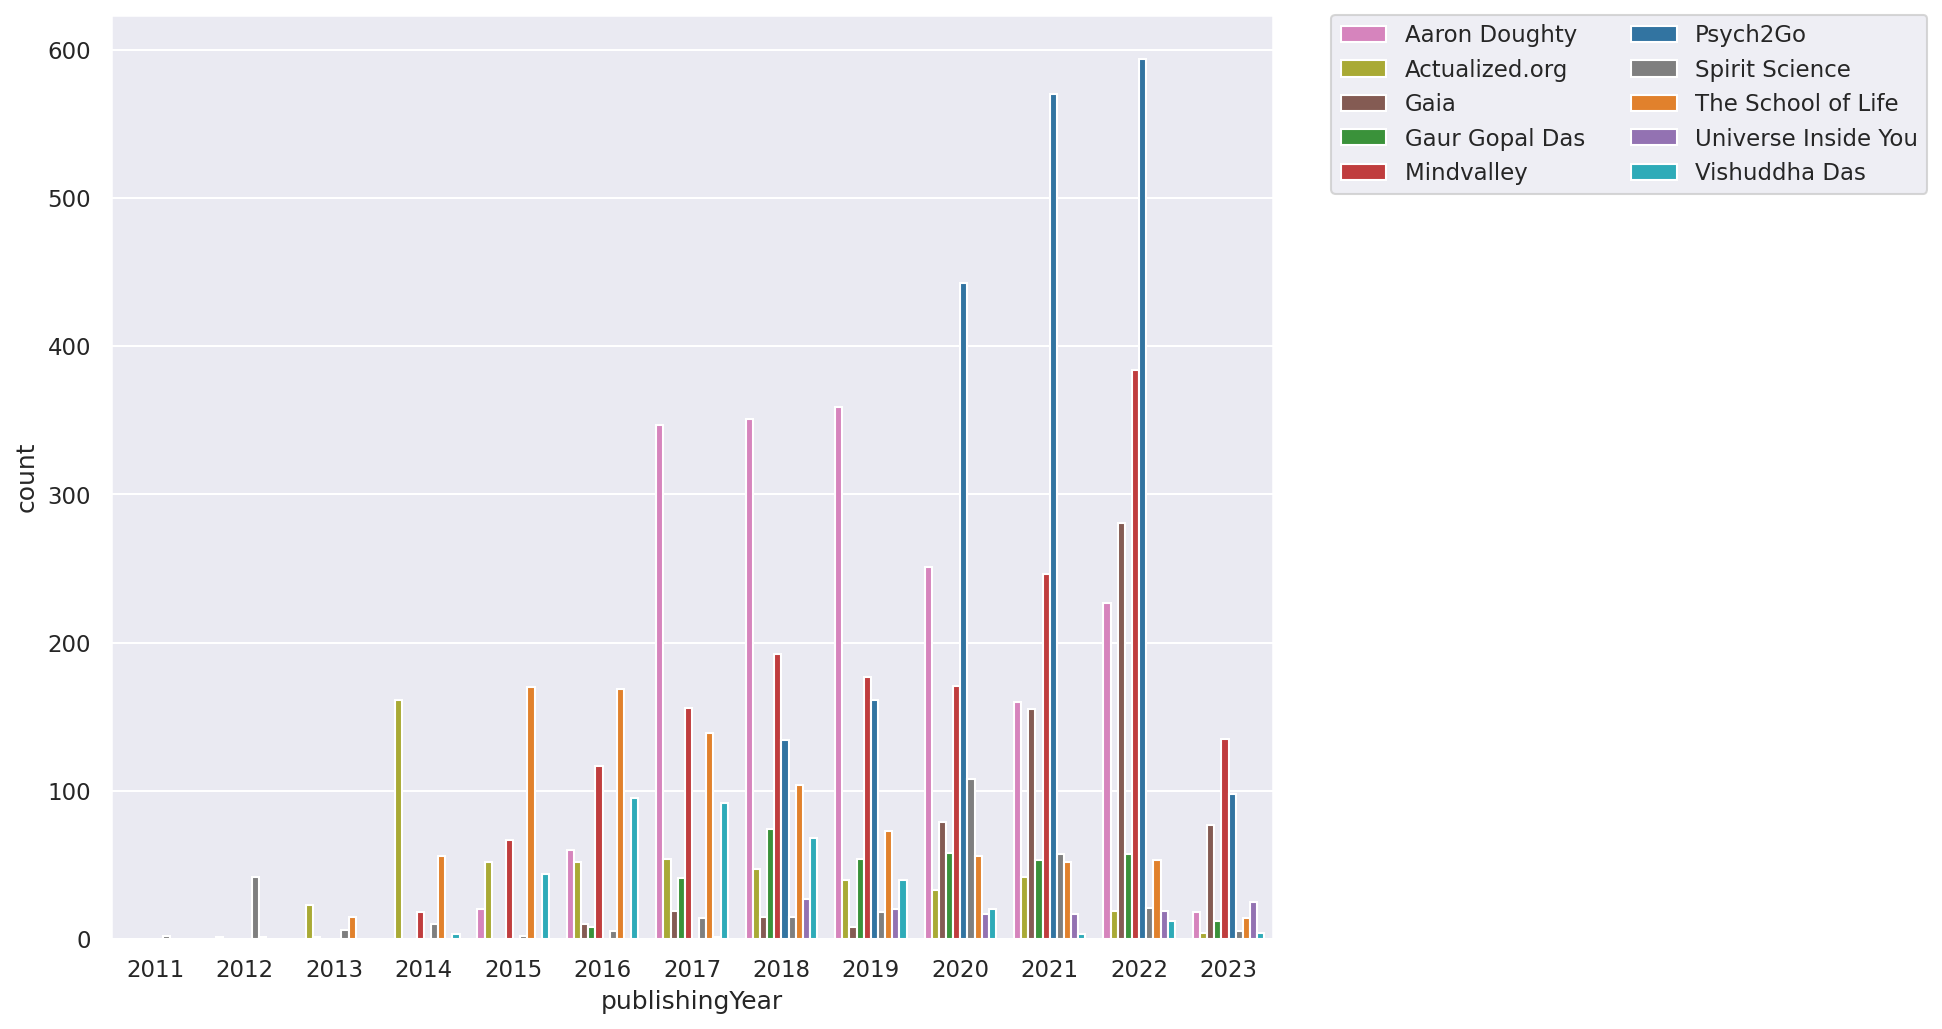

In [198]:
# group by channel and year, count the videos
count_data = viddf.groupby(['channelTitle', 'publishingYear'])['video_id'].count().reset_index(name="count")

# plot using seaborn
sns.set(rc={'figure.figsize':(10,8),'figure.dpi':150,})
ax = sns.barplot(data=count_data, x='publishingYear', y='count', hue='channelTitle', palette=channel_colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
plt.show()

### Views distribution per channel via BoxPlot and ViolinPlot

#### Observations

With the video statistics for all channel, now we can see how the views are distributed per channel. 
- Boxplot provides us with the following insights:
    - Mindvalley and Psychgo have too many videos that went viral over time.
    - The School of life and Universe inside you seem to have more broad range of video views over time as their IQR seems more via the box length.
    - I think the views and subscriber count are correlated since the channel having more subscribers tend to have more views.

- Violinplot confirms us that few channels seem to have quite variation among views of the videos, like Aaron Daughty and Vishuddha Das videos have recieved more varied views for the videos.

#### ViolinPlot

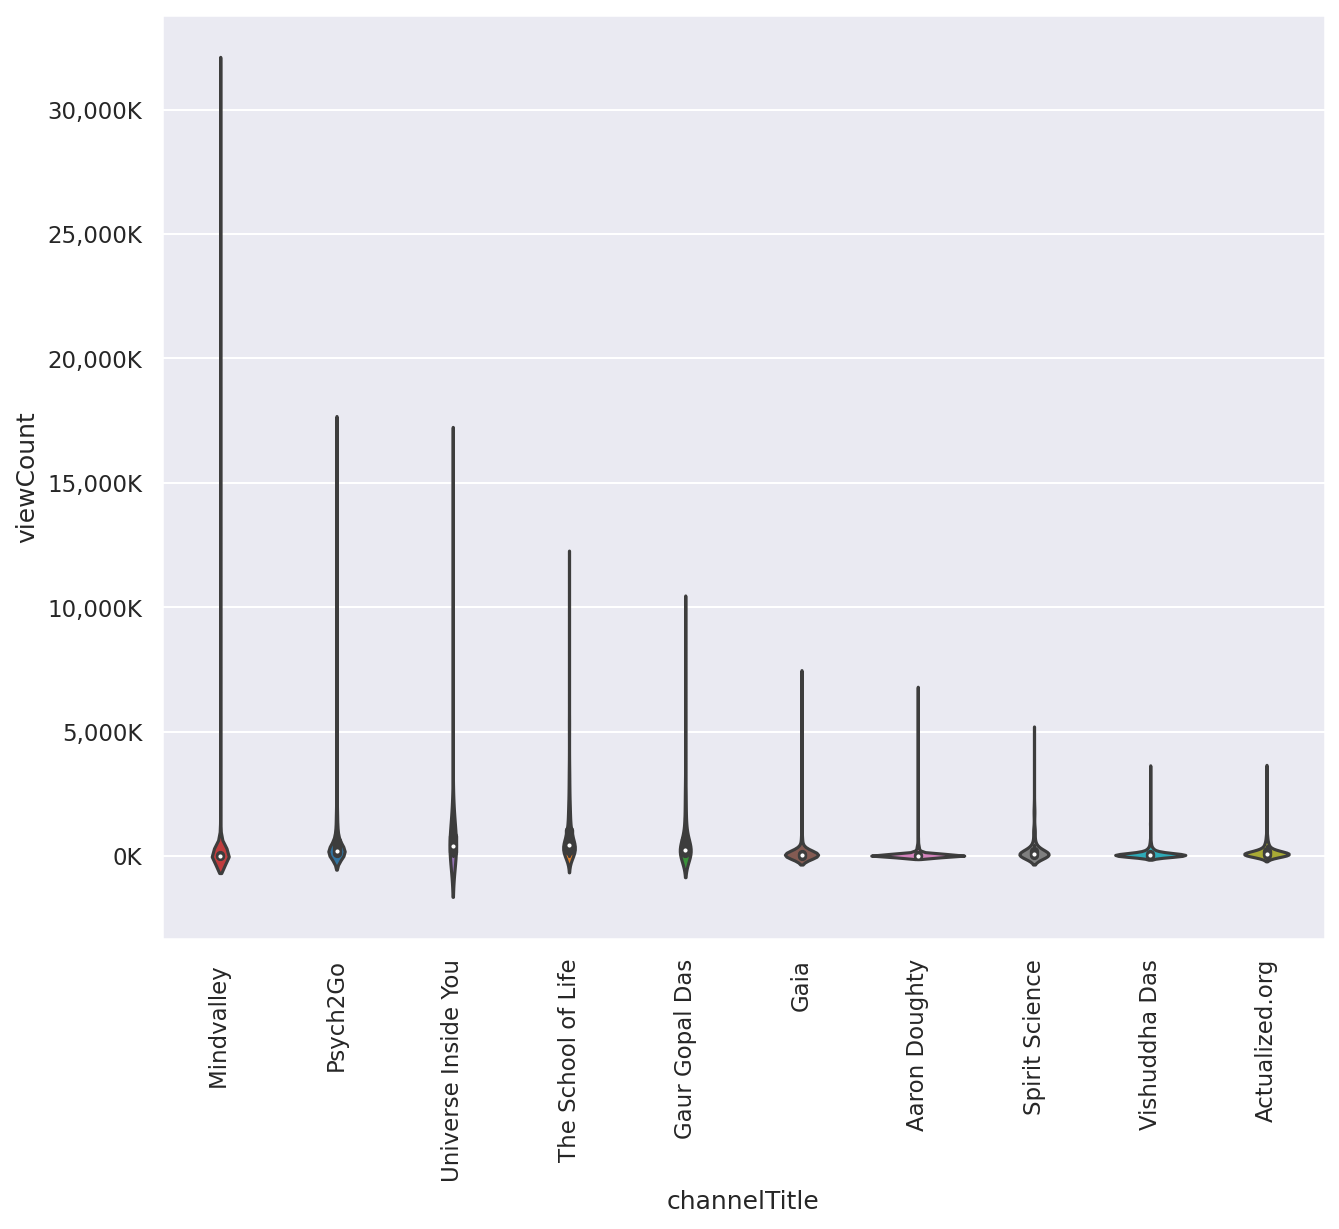

In [199]:
ax = sns.violinplot(x='channelTitle', y='viewCount', data=viddf.sort_values('viewCount', ascending=False), palette = channel_colors)
#ax.set_ylim(ymin = -1e3, ymax = 1e5)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

#### BoxPlot

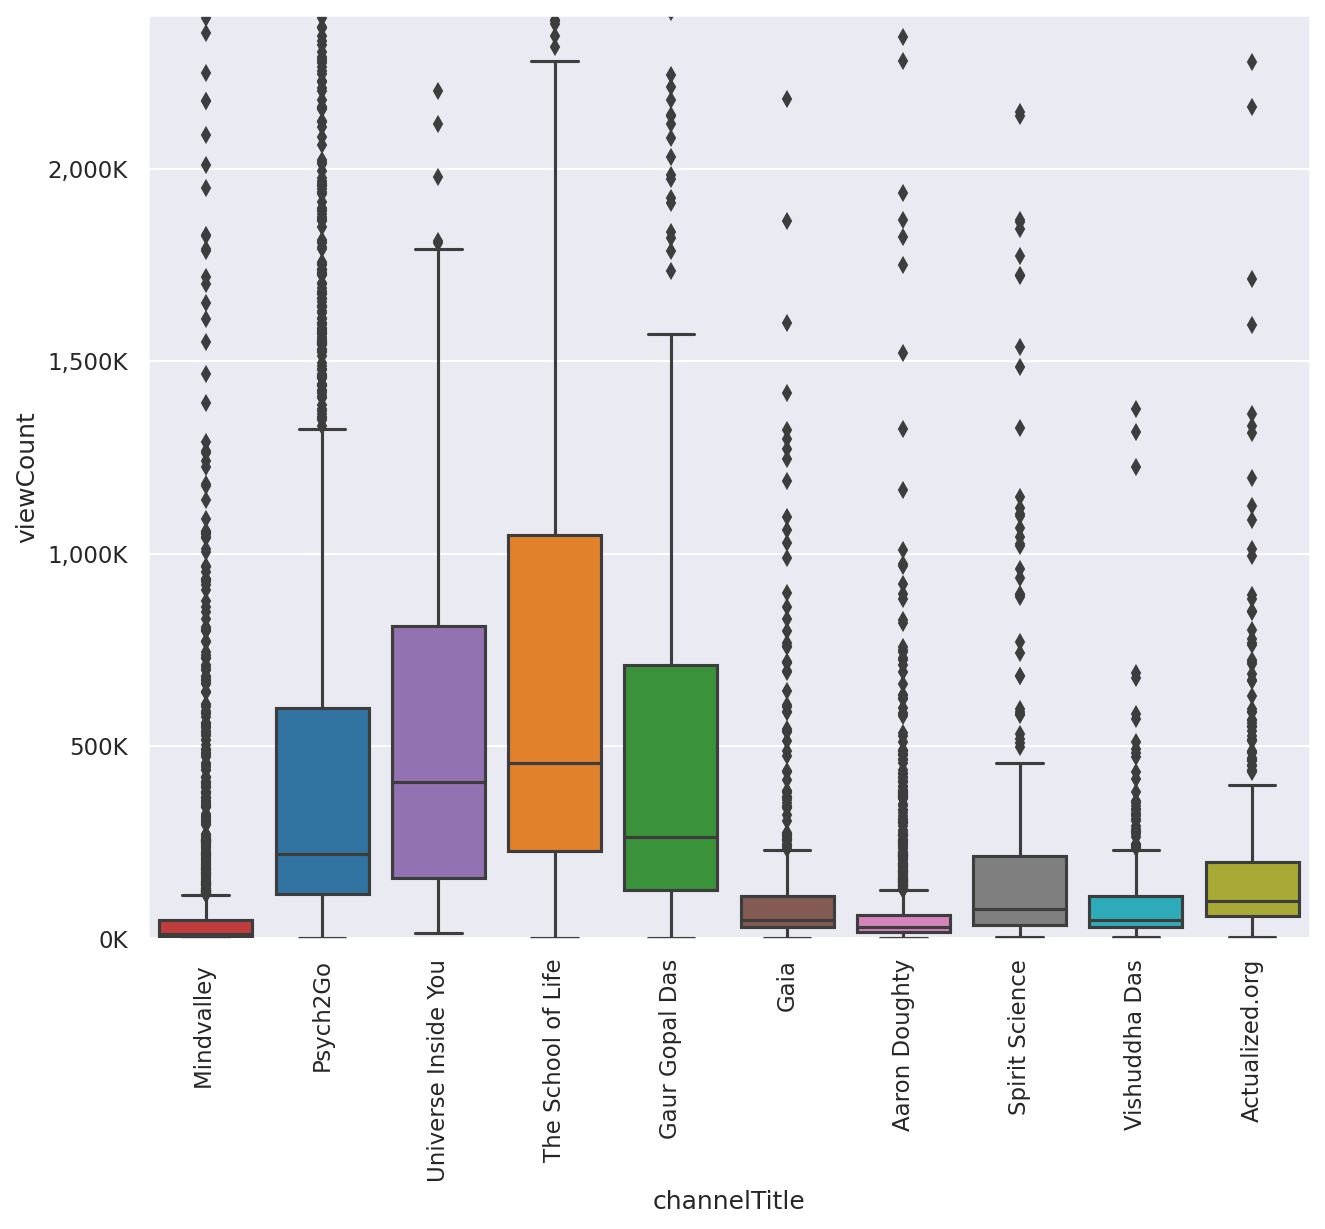

In [200]:
ax = sns.boxplot(x='channelTitle', y='viewCount', data=viddf.sort_values('viewCount', ascending=False), palette = channel_colors)
ax.set_ylim(ymin = -1e3, ymax = 2.4e6)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

#### Observations

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

#### Correlation Plots of comment count, like count vs view Count

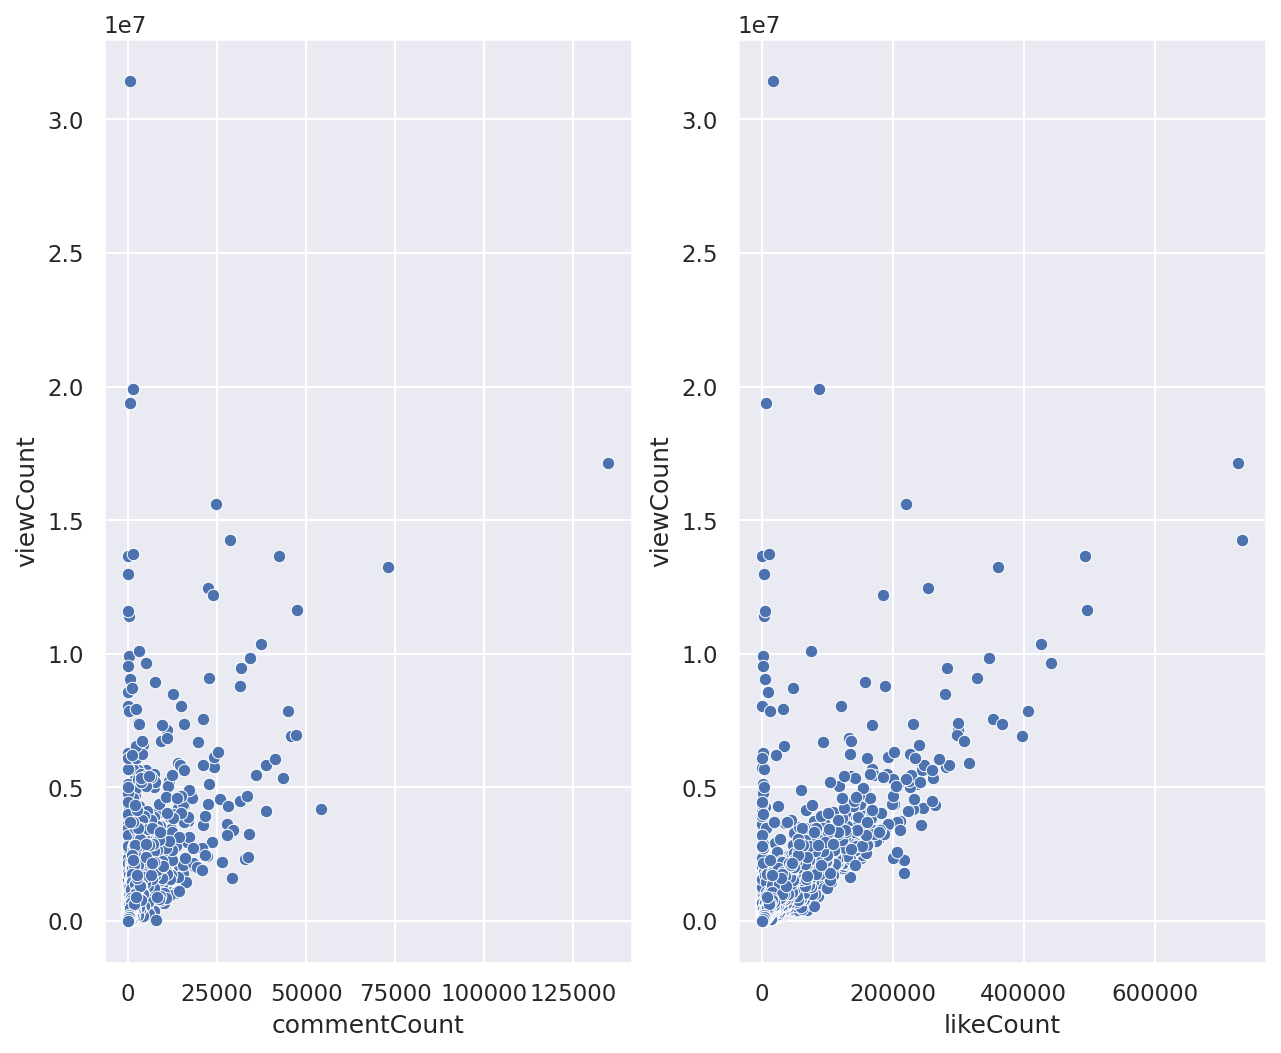

In [201]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = viddf, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = viddf, x = "likeCount", y = "viewCount", ax=ax[1])
plt.show()

#### Correlation Plots of comment ration, like ratio vs view Count

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number. It seems that more views is leading to more comments and more likes as well, but after a certain point I think, with views viewers, don't write comments that much.

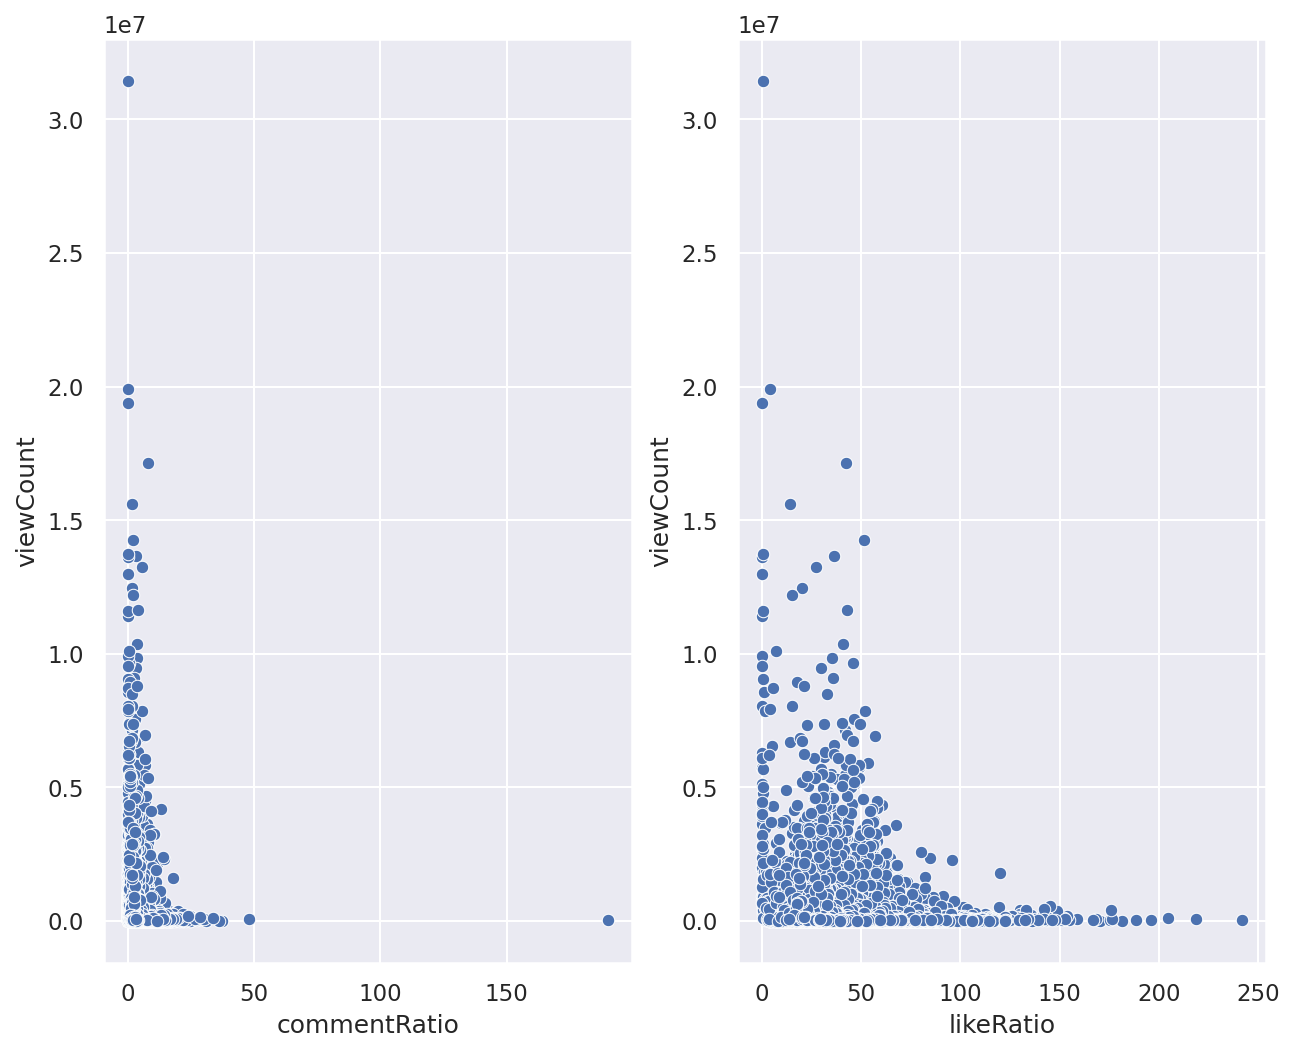

In [202]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = viddf, x = "commentRatio", y = "viewCount", ax=ax[0])
#ax[0].set_ylim(0,9e6)
#ax[1].set_ylim(0,9e6)
sns.scatterplot(data = viddf, x = "likeRatio", y = "viewCount", ax=ax[1])
plt.show()

### Does the video duration matter for views and interaction (likes/ comments)?

#### Observations

As can be seen in the histogram below, most videos are between 1600 to 1800 seconds, which is about 20 to 30 minutes. Here I have to limit the duration to 10,000 because of some really long videos (potentially streaming videos).

#### Histplot of number of videos with their duration

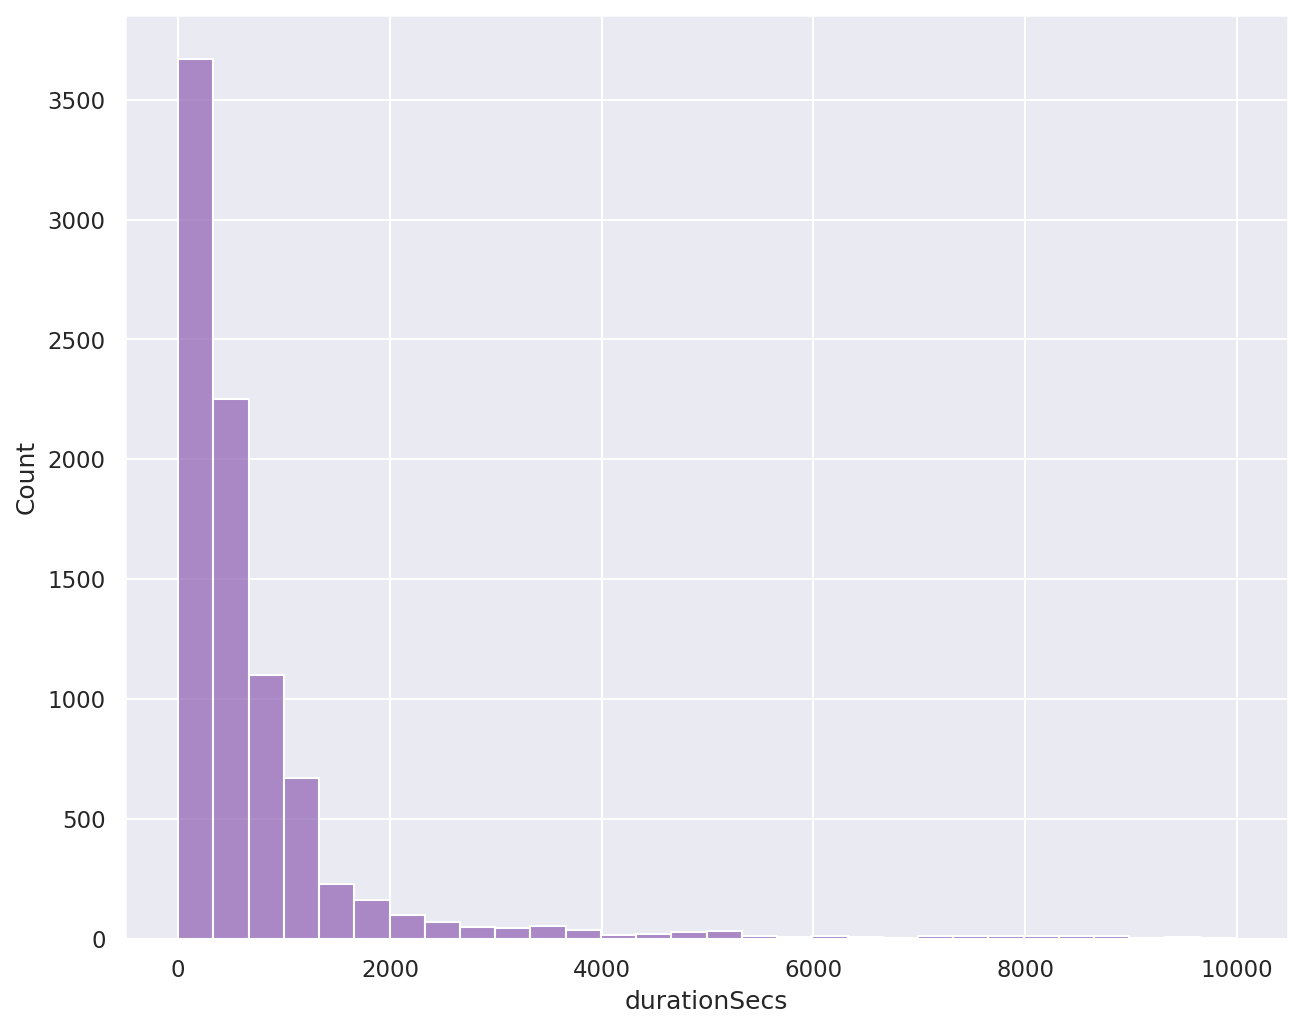

In [203]:
ax = sns.histplot(data=viddf[viddf['durationSecs'] < 10000], x="durationSecs", bins=30, color="#9368b7")
plt.show()

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

#### Duration vs Comment Count, Like Count Plots

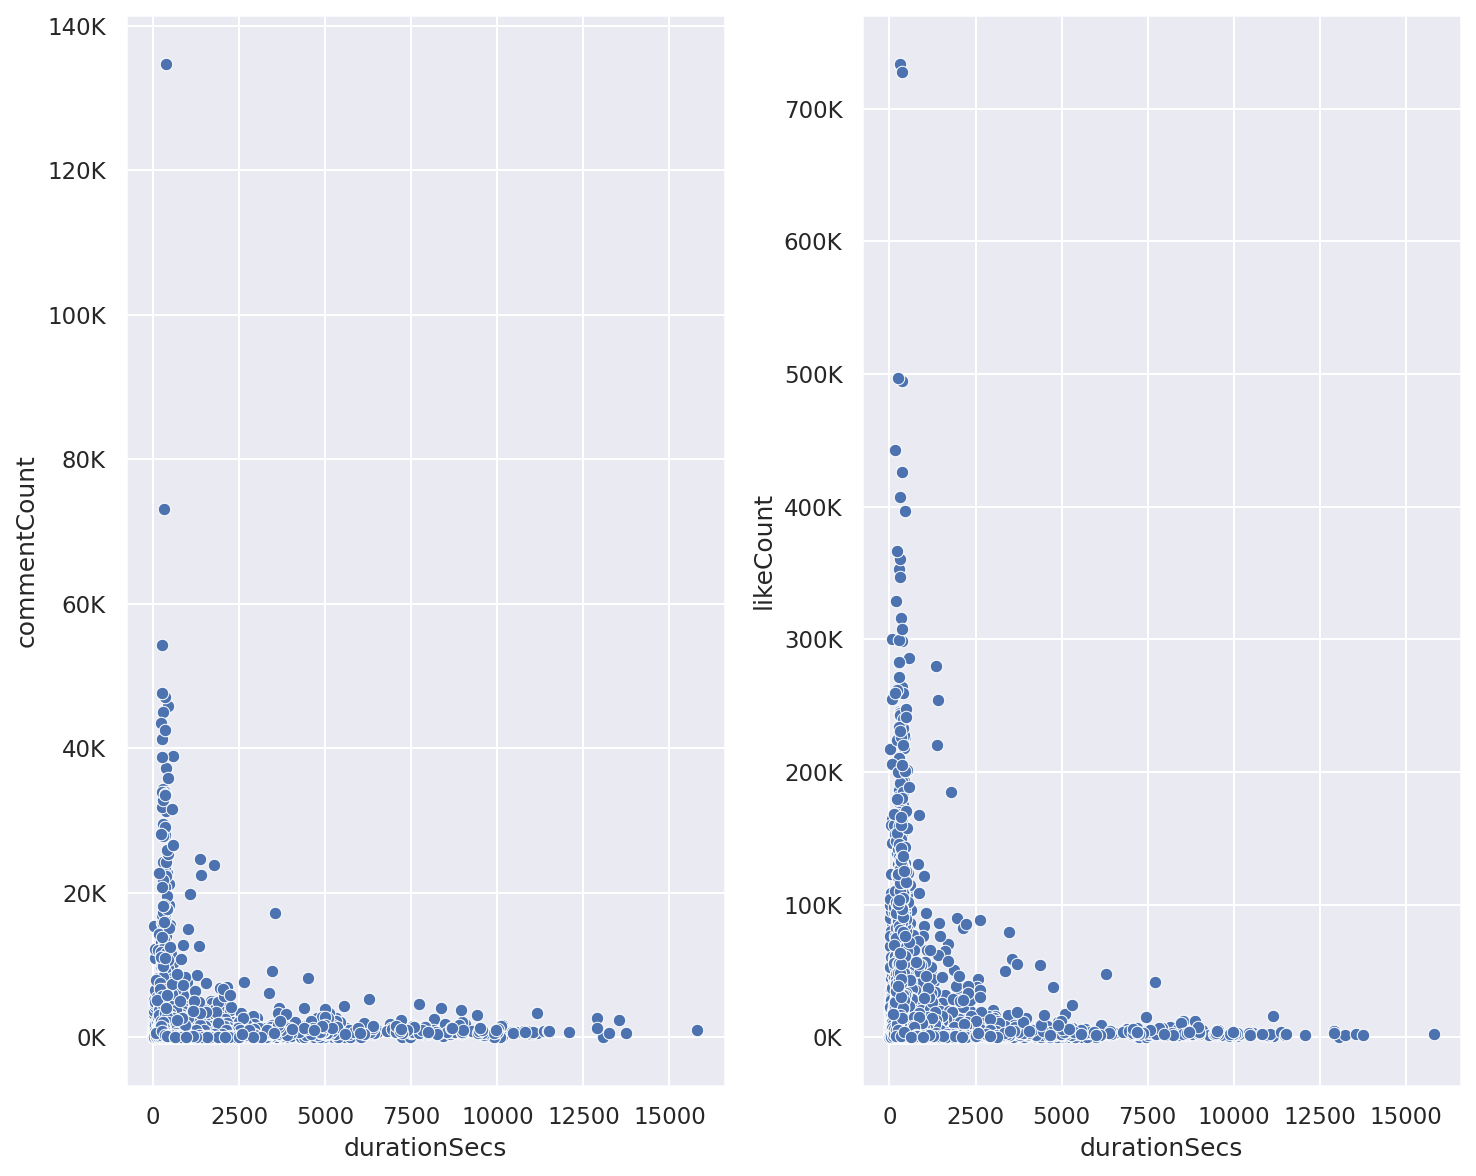

In [204]:
# matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
fig, ax =plt.subplots(1,2)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = viddf, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = viddf, x = "durationSecs", y = "likeCount", ax=ax[1])
#ax[0].set_ylim(0,1e5)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
#ax[1].set_ylim(0,1e5)
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
fig.tight_layout()
plt.show()

### Does title length matter for views?

#### Observations

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 35-60 characters

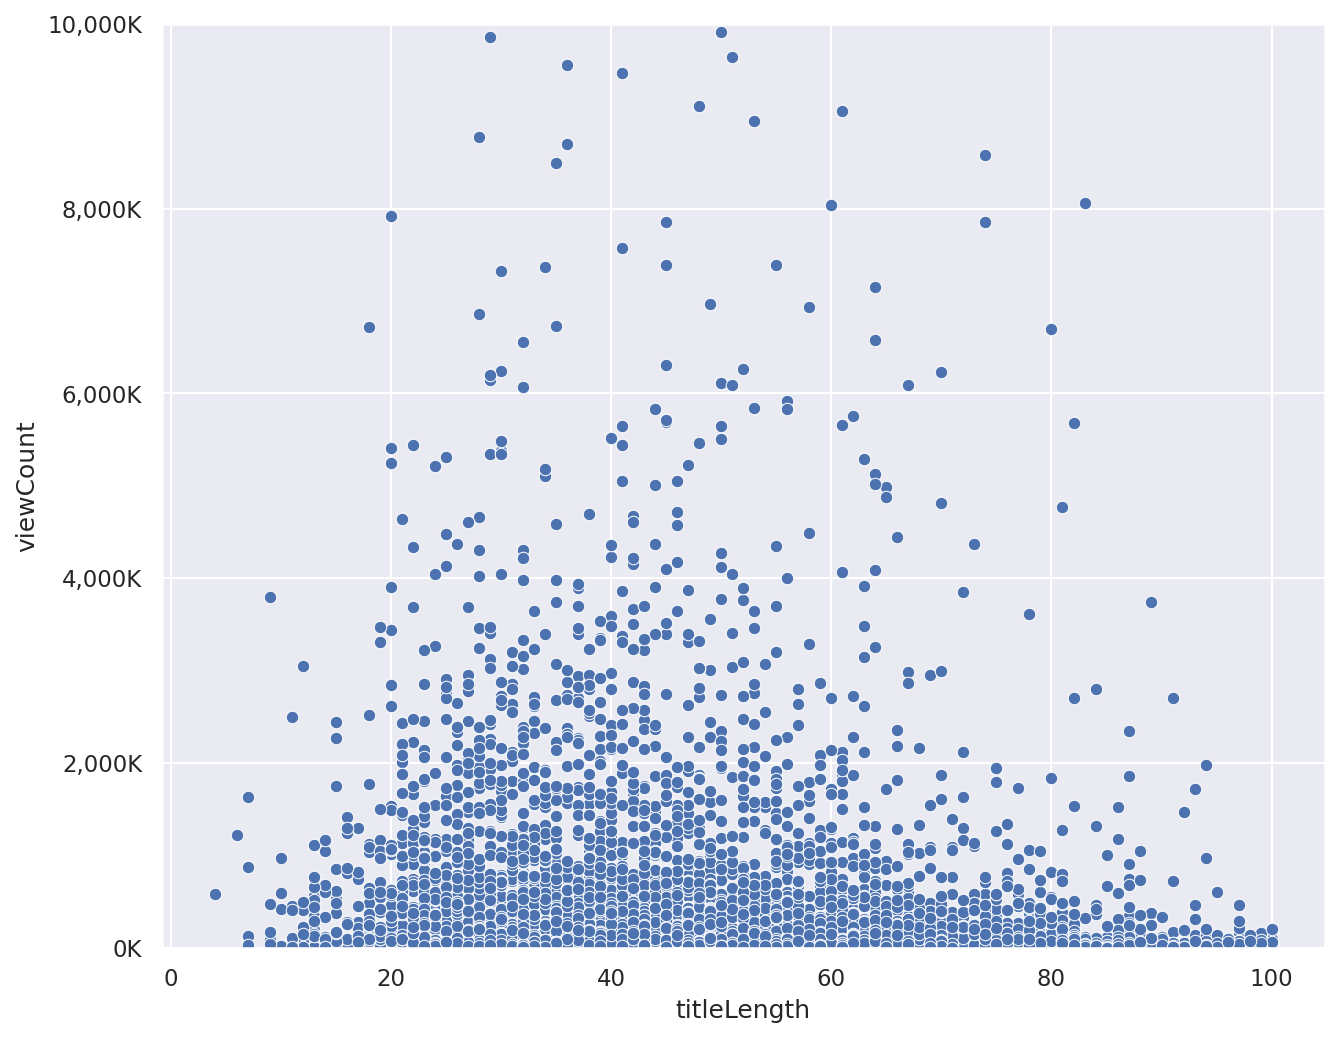

In [205]:
ax = sns.scatterplot(data = viddf, x = "titleLength", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylim(0,1e7)
plt.show()

## Wordcloud for words in title

#### Observations

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you", "I", "the", etc. which do note contribute a lot to the meaning of the title. It can be seen that the main words posted in title are Life, Attraction, Love, Meditation, People and Thing.

In [206]:
stop_words = set(stopwords.words('english'))
viddf['title_no_stopwords'] = viddf['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in viddf['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

#### WordCloud for Spiritual Content Video Titles

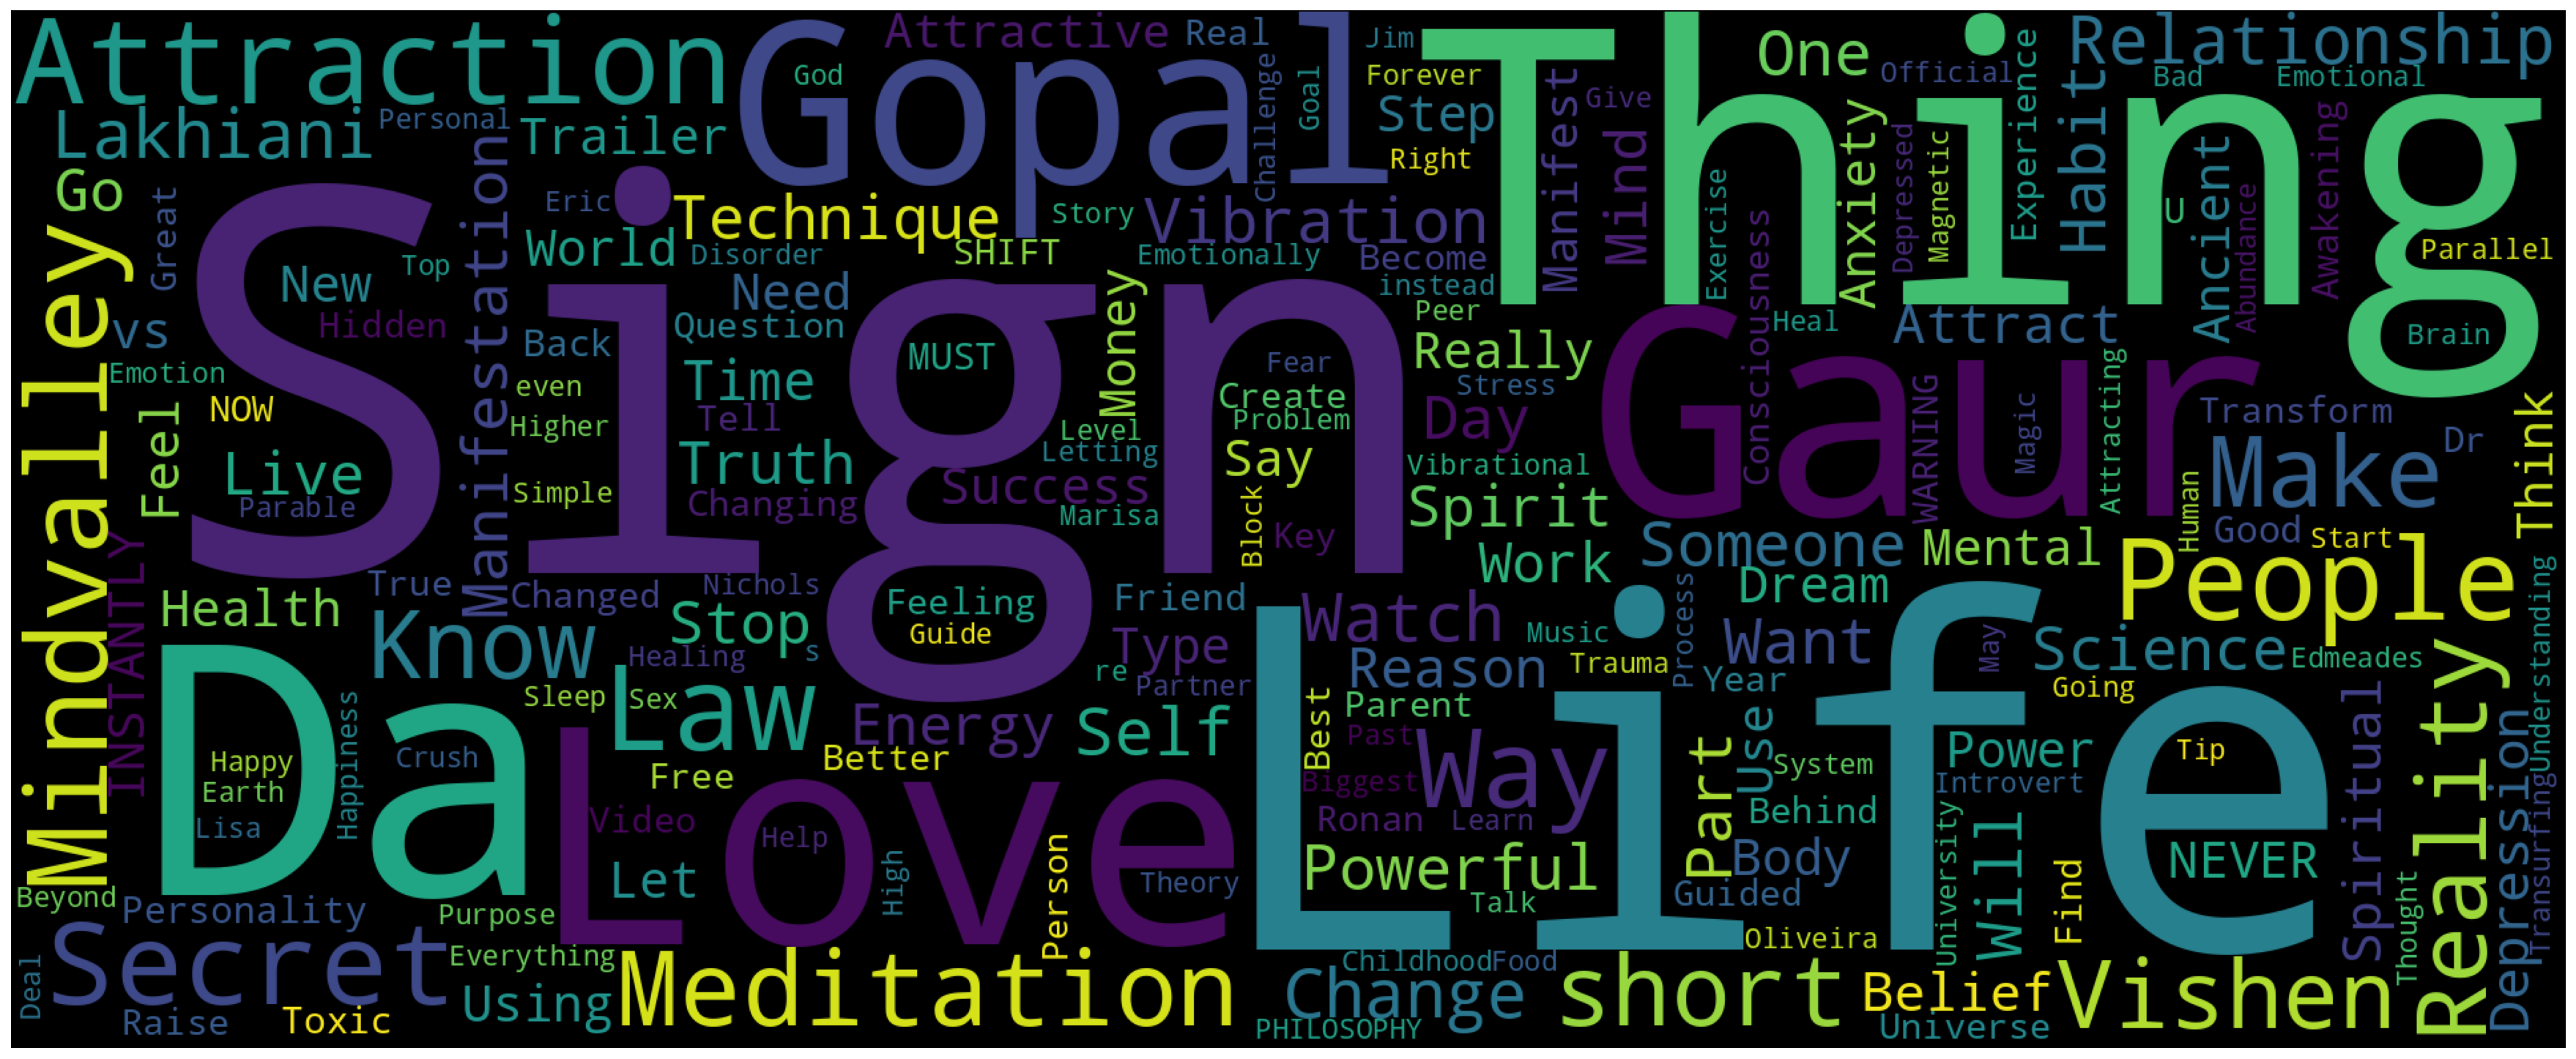

In [207]:
# matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 1920, height = 780, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)
plt.show()

In [224]:
for i in sorted(wordcloud.words_.items(), key = lambda x: x[1],reverse = False):
    if i[0] == 'sign gaur':
        print(i)

### Number of tags vs views

It seems that most videos have between 10 and 45 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

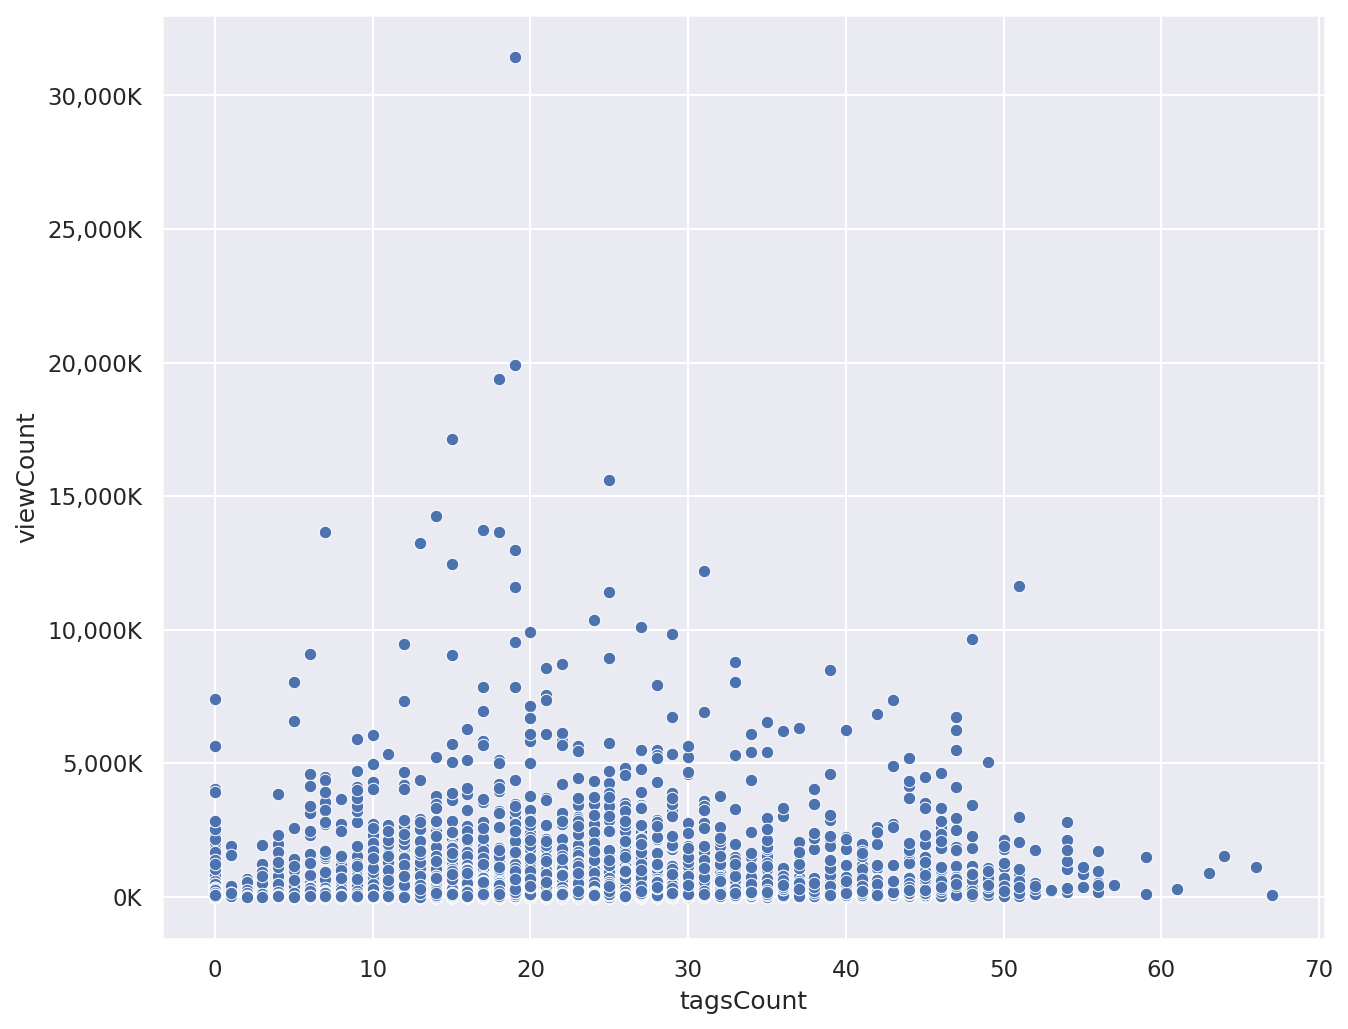

In [209]:
plot = sns.scatterplot(data = viddf, x = "tagsCount", y = "viewCount")
plot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.show()

### Which day in the week are most videos uploaded

#### Observations

It's interesting to see that more videos are uploaded on Mondays, Wednesdays and Fridays. It seems the pattern is alternative in uploading the videos. This might be because of maintaining a consistency on channel, like when the user can more expect the videos, on a consistent basis.

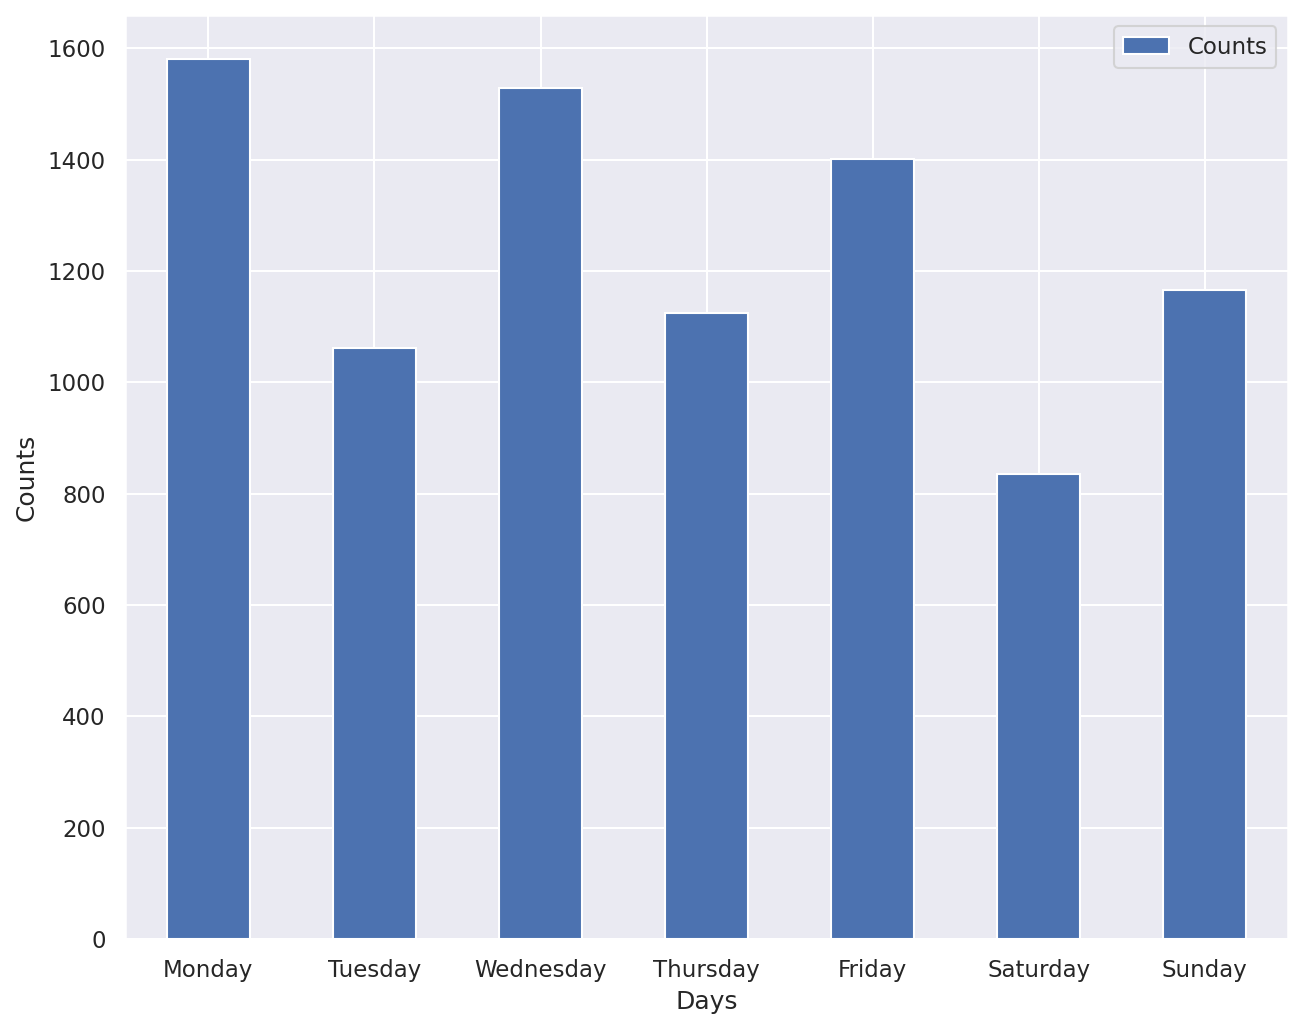

In [210]:
day_df = pd.DataFrame(viddf['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)
plt.xlabel("Days")
plt.ylabel("Counts")
plt.legend(labels = ["Counts"])
plt.show()

## Wordcloud for video comments

#### Observations

Like the video titles, the video comments also revolve around Love, Life, Sign, Thing, Attraction words

In [211]:
stop_words = set(stopwords.words('english'))
comdf['comments_no_stopwords'] = comdf['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comdf['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

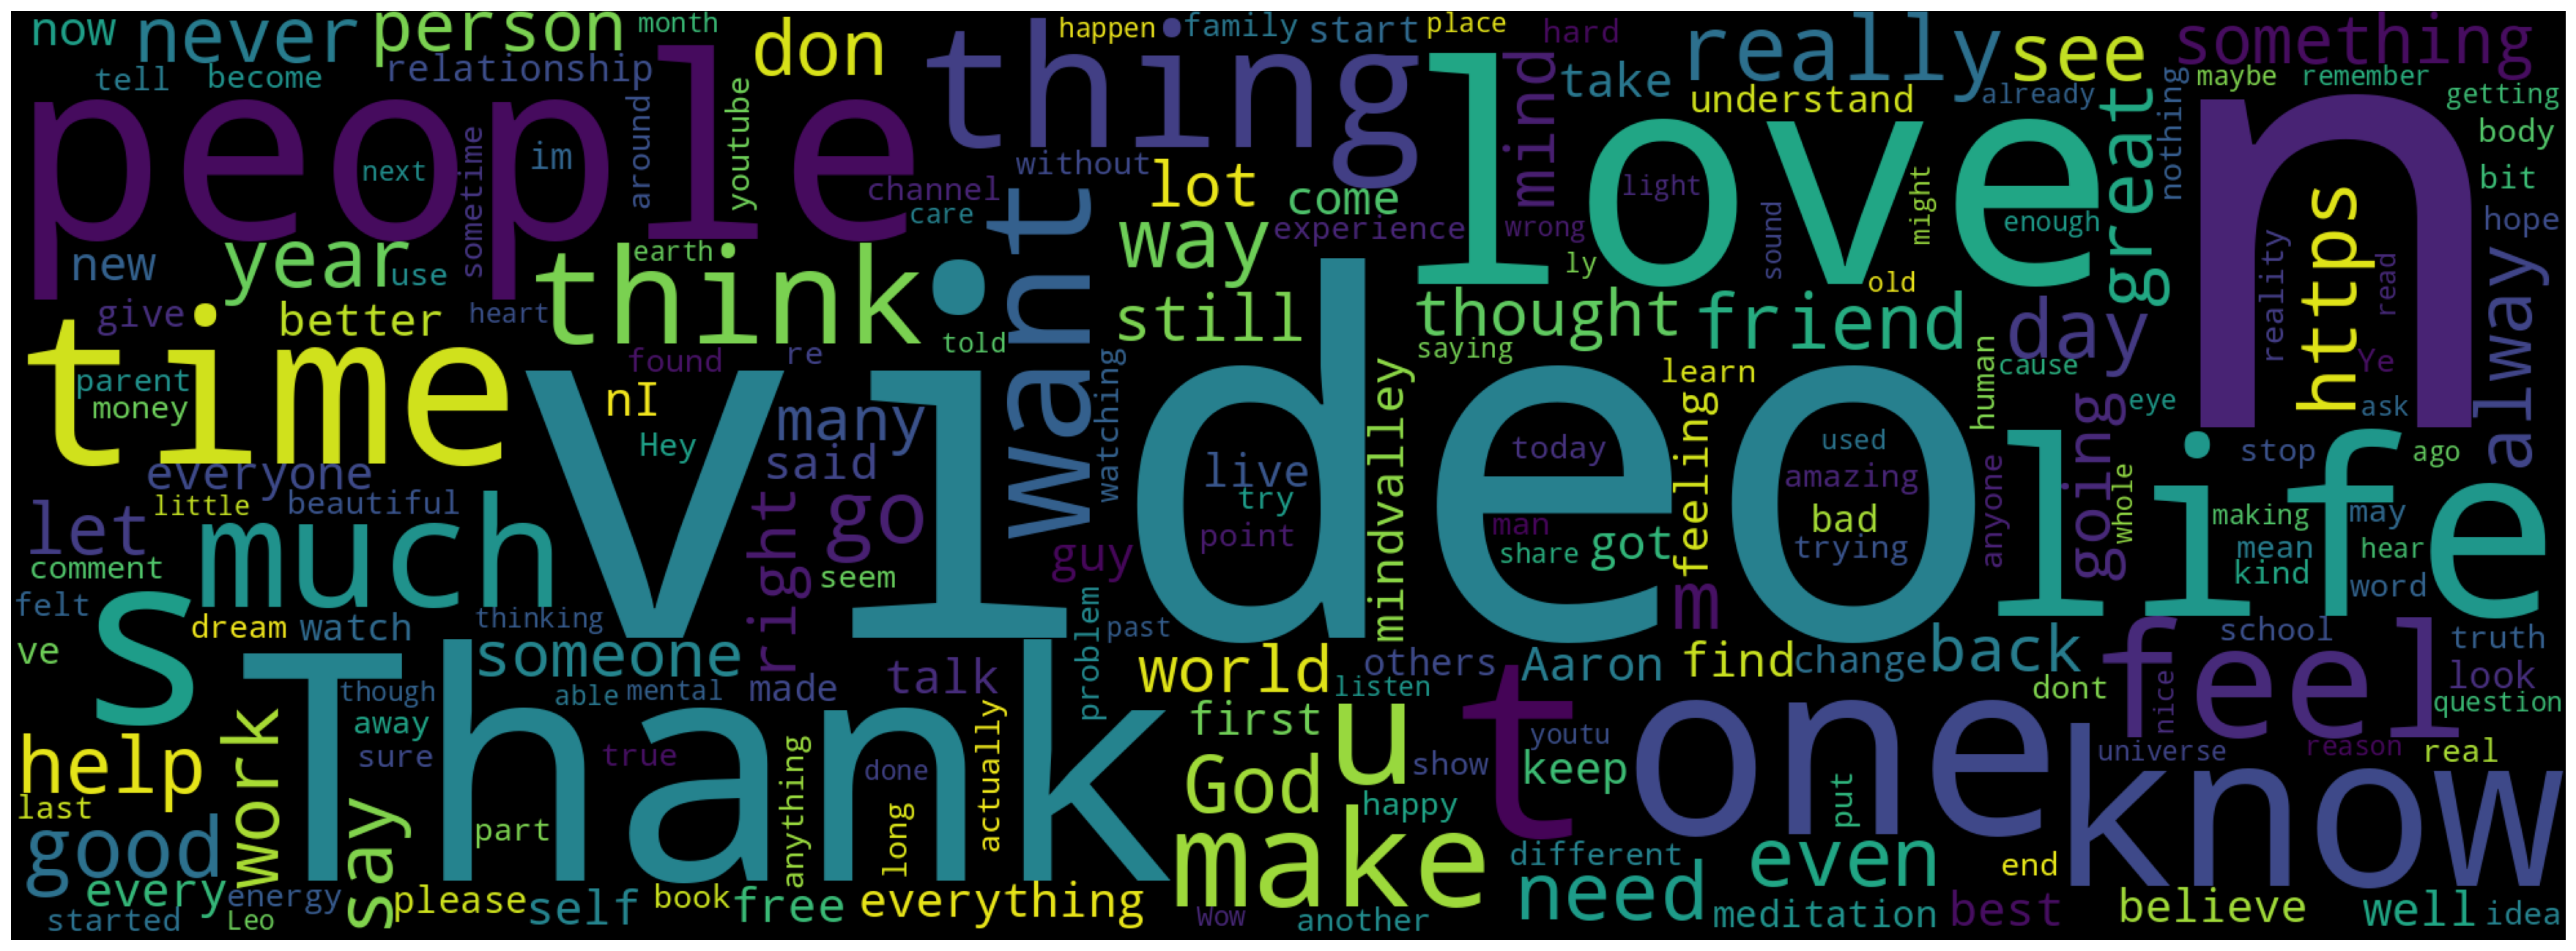

In [212]:
# matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
wordcloud = WordCloud(width = 1980, height = 720, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)
plt.show()